In [1]:
# For data
import pandas as pd
import numpy as np
import os
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import missingno as msno

# For data preprocessing
from sklearn.model_selection import train_test_split

# For modeling

# For model evaluation



# Set the style of the visualization
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('future.no_silent_downcasting', True)

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set_theme(style="white")

In [33]:
# Importing the dataset
train_data = pd.read_csv('data/train_data.csv', low_memory=False)   # low_memory=False to avoid warning message about mixed types
test_data = pd.read_csv('data/test_data.csv', low_memory=False)

In [16]:
train_data.head()

Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2019-12-30           31.0                              N    2020-01-01   
1    2019-08-30           46.0                              N    2020-01-01   
2    2019-12-06           40.0                              N    2020-01-01   
3           NaN            NaN                            NaN    2020-01-01   
4    2019-12-30           61.0                              N    2020-01-01   

  Attorney/Representative  Average Weekly Wage  Birth Year    C-2 Date  \
0                       N                 0.00      1988.0  2019-12-31   
1                       Y              1745.93      1973.0  2020-01-01   
2                       N              1434.80      1979.0  2020-01-01   
3                     NaN                  NaN         NaN         NaN   
4                       N                  NaN      1958.0  2019-12-31   

     C-3 Date                  Carrier Name Carrier Type  Claim Identifier  \
0         NaN    NEW HAMPSHIRE INSURANCE CO  1A. PRIVATE           5393875   
1  2020-01-14  ZURICH AMERICAN INSURANCE CO  1A. PRIVATE           5393091   
2         NaN     INDEMNITY INSURANCE CO OF  1A. PRIVATE           5393889   
3         NaN                           NaN          NaN         957648180   
4         NaN          STATE INSURANCE FUND      2A. SIF           5393887   

  Claim Injury Type County of Injury COVID-19 Indicator District Name  \
0       2. NON-COMP     ST. LAWRENCE                  N      SYRACUSE   
1      4. TEMPORARY          WYOMING                  N     ROCHESTER   
2      4. TEMPORARY           ORANGE                  N        ALBANY   
3               NaN              NaN                NaN           NaN   
4       2. NON-COMP         DUTCHESS                  N        ALBANY   

  First Hearing Date Gender  IME-4 Count  Industry Code  \
0                NaN      M          NaN           44.0   
1         2020-02-21      F          4.0           23.0   
2                NaN      M          NaN           56.0   
3                NaN    NaN          NaN            NaN   
4                NaN      M          NaN           62.0   

                           Industry Code Description Medical Fee Region  \
0                                       RETAIL TRADE                  I   
1                                       CONSTRUCTION                  I   
2  ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...                 II   
3                                                NaN                NaN   
4                  HEALTH CARE AND SOCIAL ASSISTANCE                 II   

   OIICS Nature of Injury Description  WCIO Cause of Injury Code  \
0                                 NaN                       27.0   
1                                 NaN                       97.0   
2                                 NaN                       79.0   
3                                 NaN                        NaN   
4                                 NaN                       16.0   

  WCIO Cause of Injury Description  WCIO Nature of Injury Code  \
0     FROM LIQUID OR GREASE SPILLS                        10.0   
1                REPETITIVE MOTION                        49.0   
2   OBJECT BEING LIFTED OR HANDLED                         7.0   
3                              NaN                         NaN   
4  HAND TOOL, UTENSIL; NOT POWERED                        43.0   

  WCIO Nature of Injury Description  WCIO Part Of Body Code  \
0                         CONTUSION                    62.0   
1                    SPRAIN OR TEAR                    38.0   
2                        CONCUSSION                    10.0   
3                               NaN                     NaN   
4                          PUNCTURE                    36.0   

  WCIO Part Of Body Description Zip Code  Agreement Reached      WCB Decision  \
0                      BUTTOCKS    13662                0.0  Not Work Related   
1                   S

In [47]:
regional_columns = ['Zip Code', 'District Name', 'County of Injury', 'Industry Code', 'Industry Code Description', 'Medical Fee Region']
rdata_train = train_data.loc[:, regional_columns]
rdata_test = test_data.loc[:, regional_columns]
train_target = train_data['Claim Injury Type']

rdata_train['Industry Code'] = rdata_train['Industry Code'].astype('category')

- **13** *County of Injury:* Name of the New York County where the injury occurred.
- **15** *District Name:* Name of the WCB district office that oversees claims for that region or area of the state.
- **19** *Industry Code:* [NAICS code and descriptions](https://www.naics.com/search-naics-codes-by-industry/).
- **20** *Industry Code Description:* 2-digit NAICS industry code description used to classify businesses according to their economic activity.- **21** *Medical Fee Region*  Approximate region where the injured worker would receive medical service
- **29** *Zip Code* The reported ZIP code of the injured worker's home address|

# **Part 1:** Individual feature analysis

## **Missing Values**

In [295]:
rdata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Zip Code                   545389 non-null  object 
 1   District Name              574026 non-null  object 
 2   County of Injury           574026 non-null  object 
 3   Industry Code              564068 non-null  float64
 4   Industry Code Description  564068 non-null  object 
 5   Medical Fee Region         574026 non-null  object 
dtypes: float64(1), object(5)
memory usage: 27.2+ MB


In [336]:
rdata_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387975 entries, 0 to 387974
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Zip Code                   368633 non-null  object 
 1   District Name              387975 non-null  object 
 2   County of Injury           387975 non-null  object 
 3   Industry Code              380239 non-null  float64
 4   Industry Code Description  380239 non-null  object 
 5   Medical Fee Region         387975 non-null  object 
dtypes: float64(1), object(5)
memory usage: 17.8+ MB


In [358]:
print(pd.DataFrame(
    {'train':rdata_train.isna().sum()/rdata_train.shape[0],
      'test':rdata_test.isna().sum()/rdata_test.shape[0]
}).to_latex())

\begin{tabular}{lrr}
\toprule
 & train & test \\
\midrule
Zip Code & 0.081018 & 0.049854 \\
District Name & 0.032765 & 0.000000 \\
County of Injury & 0.032765 & 0.000000 \\
Industry Code & 0.049544 & 0.019939 \\
Industry Code Description & 0.049544 & 0.019939 \\
Medical Fee Region & 0.032765 & 0.000000 \\
\bottomrule
\end{tabular}



In [317]:
any_missing_data_train = rdata_train[rdata_train.isna().any(axis=1)]
all_missing_data_train = rdata_train[rdata_train.isna().all(axis=1)]

any_missing_data_test = rdata_test[rdata_test.isna().any(axis=1)]
all_missing_data_test = rdata_test[rdata_test.isna().all(axis=1)]

In [333]:
nan_train = pd.DataFrame({
    '%Records with at least one NAN': [any_missing_data_train.shape[0]/rdata_train.shape[0]*100], 
    '%Records with only NAN': [all_missing_data_train.shape[0]/rdata_train.shape[0]*100]
             })
display(nan_train)

%Records with at least one NAN  %Records with only NAN
0                         9.69365                3.276487

In [331]:
nan_test = pd.DataFrame({
    '%Records with at least one NAN': [any_missing_data_test.shape[0]/rdata_train.shape[0]*100], 
    '%Records with only NAN': [all_missing_data_test.shape[0]/rdata_train.shape[0]*100]
             })
display(nan_test)

%Records with at least one NAN  %Records with only NAN
0                        4.498282                     0.0

`~10% of records have at least one missing value, and one third of them have no values at all`

In [303]:
ls = any_missing_data.columns.tolist()
nan_prop = pd.DataFrame(columns=ls)
for col1 in ls:
    prop = any_missing_data[col1].isna().sum()/any_missing_data.shape[0]
    nan_prop.loc[col1, col1] = prop

for col1 in ls:
    for col2 in ls[ls.index(col1)+1:]:   
        prop = any_missing_data[[col1, col2]].isna().all(axis=1).sum()/any_missing_data.shape[0]
        nan_prop.loc[col1, col2] = prop
        for col3 in ls[ls.index(col2)+1:]:
            prop = any_missing_data[[col1, col2, col3]].isna().all(axis=1).sum()/any_missing_data.shape[0]
            nan_prop.loc[col3, col2] = '{0} \n '.format(col1) + str(prop)

display(nan_prop)

Zip Code                   District Name  \
Zip Code                   0.835787                        0.338003   
District Name                   NaN                        0.338003   
County of Injury                NaN  Zip Code \n 0.3380034417424256   
Industry Code                   NaN  Zip Code \n 0.3380034417424256   
Industry Code Description       NaN  Zip Code \n 0.3380034417424256   
Medical Fee Region              NaN  Zip Code \n 0.3380034417424256   

                                              County of Injury  \
Zip Code                                              0.338003   
District Name                                         0.338003   
County of Injury                                      0.338003   
Industry Code              District Name \n 0.3380034417424256   
Industry Code Description  District Name \n 0.3380034417424256   
Medical Fee Region         District Name \n 0.3380034417424256   

                                                    Industry Code  \
Zip Code                                                 0.346886   
District Name                                            0.338003   
County of Injury                                         0.338003   
Industry Code                                            0.511099   
Industry Code Description  County of Injury \n 0.3380034417424256   
Medical Fee Region         County of Injury \n 0.3380034417424256   

                                     Industry Code Description  \
Zip Code                                              0.346886   
District Name                                         0.338003   
County of Injury                                      0.338003   
Industry Code                                         0.511099   
Industry Code Description                             0.511099   
Medical Fee Region         Industry Code \n 0.3380034417424256   

                          Medical Fee Region  
Zip Code                            0.338003  
District Name                       0.338003  
County of Injury                    0.338003  
Industry Code                       0.338003  
Industry Code Description           0.338003  
Medical Fee Region                  0.338003

`This dataframe shows the proportions of records that present pairwise or triplewise all NAN in the rows specified. On the diagonal appears the contribution proportion of one column to NANs on the df.`
<br>`It wants to measure a "causal correlation" in presence of NAN among different columns.`
<br>`AFAICS, there seems not to be such a relationship, but a note for one pair: half of the non registered Industry Codes doesn't have the Industry Code Description registered as well.`
<br>`As we expected from the very previous analysis, about one third of the incomplete records are actually fully incomplete (0.33 everywhere)`

## Univariate Analysis
Create a funtion that shows everything I want to see:
- summary of values (.describe())
- percentage of missing values
- percentage of numeric values
- whether the values are 'object' because of presence of NaNs, but it's actually numeric
- frequencies
- BOXPLOTS ARE NOT RELEVANT FOR THESE KIND OF VARIABLES
- outliers and kind of

In [207]:
def UnivariateAnalysis(col, hist=False, figsize=(10,10)):
    n_train = rdata_train[col].shape[0]
    n_test = rdata_test[col].shape[0]
    
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    summary_train = rdata_train[col].describe(percentiles = quantiles)
    
    na_indexes = rdata_train[col][rdata_train[col].isna()].index
    na_quantity = rdata_train[col][na_indexes].shape[0]
    na_percentage = na_quantity/n_train
    summary_train['%_na'] = na_percentage*100

    
    numeric_indexes = rdata_train[col][rdata_train[col].str.isnumeric().fillna(False)].index

    non_na_indexes = rdata_train[col].dropna().index
    non_numeric_indexes = np.setxor1d(non_na_indexes, numeric_indexes)
    are_all_numeric = np.logical_not(non_numeric_indexes.any())
    summary_train['is_actually_numeric'] = are_all_numeric

    if numeric_indexes.any():
        
        numeric_quantity = rdata_train[col][numeric_indexes].shape[0]
        numeric_percentage = numeric_quantity/n_train
        summary_train['%_num'] = numeric_percentage*100
    
        numeric_frequencies = rdata_train[col][numeric_indexes].value_counts()
        summary_train['numeric mode'] = (numeric_frequencies.index[0], numeric_frequencies.values[0])
    
    if not are_all_numeric:
        non_numeric_frequencies = rdata_train[col][non_numeric_indexes].value_counts()
        summary_train['non numeric mode'] = (non_numeric_frequencies.index[0], non_numeric_frequencies.values[0])

######################à
    summary_test = rdata_test[col].describe(percentiles = quantiles)
    
    na_indexes = rdata_test[col][rdata_test[col].isna()].index
    na_quantity = rdata_test[col][na_indexes].shape[0]
    na_percentage = na_quantity/n_test
    summary_test['%_na'] = na_percentage*100

    
    numeric_indexes = rdata_test[col][rdata_test[col].str.isnumeric().fillna(False)].index

    non_na_indexes = rdata_test[col].dropna().index
    non_numeric_indexes = np.setxor1d(non_na_indexes, numeric_indexes)
    are_all_numeric = np.logical_not(non_numeric_indexes.any())
    summary_test['is_actually_numeric'] = are_all_numeric

    if numeric_indexes.any():
        
        numeric_quantity = rdata_test[col][numeric_indexes].shape[0]
        numeric_percentage = numeric_quantity/n_test
        summary_test['%_num'] = numeric_percentage*100
    
        numeric_frequencies = rdata_test[col][numeric_indexes].value_counts()
        summary_test['numeric mode'] = (numeric_frequencies.index[0], numeric_frequencies.values[0])
    
    if not are_all_numeric:
        non_numeric_frequencies = rdata_test[col][non_numeric_indexes].value_counts()
        summary_test['non numeric mode'] = (non_numeric_frequencies.index[0], non_numeric_frequencies.values[0])
##########################
    summary = pd.concat([summary_train, summary_test], axis=1)
    display(summary)

    limit_train = rdata_train[col].value_counts().iloc[-1]
    limit_test = rdata_test[col].value_counts().iloc[-1]
    outl = pd.DataFrame({
        'train outliers': rdata_train[col].value_counts()[rdata_train[col].value_counts() == limit_train],
        'test outliers': rdata_test[col].value_counts()[rdata_test[col].value_counts() == limit_test]
            }).T
    display(outl)
 
    
    if hist:
        fig, axs = plt.subplots(figsize=figsize)
        axs = rdata_train[col].value_counts().sort_values(ascending=False).plot(kind='barh', color='green', label='train');
        axs2 = axs.twinx() 
        axs2 = rdata_test[col].value_counts().sort_values(ascending=False).plot(kind='barh', color='orange', label='test');
        fig.legend()
        plt.savefig('{0}_barplot.png'.format(col))
        plt.show()

    return {'summary': summary, 'outliers': outl}

### Zip Code

In [213]:
# UnivariateAnalysis(rdata_train['Zip Code']) too expensive, too many possible values
zip_code = UnivariateAnalysis('Zip Code')

Zip Code       Zip Code
count                       545389         368633
unique                        8286           6276
top                          11236          11368
freq                          3398           2068
%_na                      8.101828       4.985373
is_actually_numeric          False          False
%_num                    91.839534        94.9422
numeric mode         (11236, 3398)  (11368, 2068)
non numeric mode       (V6T1Z, 41)    (M3K2C, 45)

Zip Code        .1605  00001  00011  00520  00601  00603  00605  00610  00624  \
train outliers    1.0    NaN    1.0    NaN    1.0    NaN    NaN    NaN    1.0   
test outliers     NaN    1.0    NaN    1.0    1.0    1.0    1.0    1.0    NaN   

Zip Code        00627  00637  00641  00659  00660  00664  00669  00678  00685  \
train outliers    1.0    NaN    1.0    NaN    1.0    NaN    1.0    1.0    1.0   
test outliers     NaN    1.0    NaN    1.0    1.0    1.0    NaN    NaN    NaN   

Zip Code        00692  00698  00704  00726  00727  00730  00731  00735  00737  \
train outliers    1.0    1.0    NaN    1.0    1.0    1.0    1.0    1.0    1.0   
test outliers     NaN    NaN    1.0    NaN    1.0    NaN    1.0    NaN    1.0   

Zip Code        00739  00745  00749  00754  00757  00767  00769  00772  00775  \
train outliers    1.0    NaN    1.0    1.0    1.0    NaN    NaN    1.0    1.0   
test outliers     NaN    1.0    NaN    NaN    NaN    1.0    1.0    NaN    NaN   

Zip Code        00780  00782  00783  00784  00801  00817  00830  00859  00901  \
train outliers    1.0    NaN    1.0    NaN    1.0    1.0    NaN    1.0    1.0   
test outliers     NaN    1.0    NaN    1.0    NaN    NaN    1.0    NaN    NaN   

Zip Code        00912  00925  00926  00927  00949  00952  00956  00959  00962  \
train outliers    1.0    1.0    1.0    1.0    NaN    1.0    1.0    NaN    1.0   
test outliers     NaN    NaN    1.0    NaN    1.0    1.0    NaN    1.0    NaN   

Zip Code        00965  00968  00969  00981  00982  00983  01001  01005  01007  \
train outliers    NaN    1.0    NaN    NaN    1.0    NaN    1.0    NaN    1.0   
test outliers     1.0    NaN    1.0    1.0    NaN    1.0    NaN    1.0    1.0   

Zip Code        01010  01020  01027  01031  01033  01034  01037  01056  01057  \
train outliers    NaN    NaN    1.0    1.0    NaN    1.0    NaN    NaN    1.0   
test outliers     1.0    1.0    NaN    NaN    1.0    NaN    1.0    1.0    NaN   

Zip Code        01060  01062  01070  01075  01077  01082  01083  01085  01089  \
train outliers    NaN    1.0    NaN    1.0    1.0    NaN    1.0    NaN    NaN   
test outliers     1.0    1.0    1.0    NaN    NaN    1.0    NaN    1.0    1.0   

Zip Code        01096  01101  01105  01106  01107  01108  01119  01129  01158  \
train outliers    1.0    1.0    1.0    1.0    1.0    1.0    NaN    1.0    NaN   
test outliers     NaN    NaN    NaN    1.0    NaN    1.0    1.0    NaN    1.0   

Zip Code        01174  01202  01222  01225  01236  01238  01240  01242  01254  \
train outliers    NaN    NaN    1.0    1.0    1.0    NaN    NaN    1.0    1.0   
test outliers     1.0    1.0    NaN    NaN    NaN    1.0    1.0    NaN    1.0   

Zip Code        01257  01258  01259  01262  01266  01267  01301  01331  01334  \
train outliers    1.0    NaN    1.0    NaN    NaN    NaN    1.0    1.0    NaN   
test outliers     NaN    1.0    NaN    1.0    1.0    1.0    1.0    NaN    1.0   

Zip Code        01339  01341  01360  01364  01370  01376  01421  01430  01440  \
train outliers    1.0    NaN    NaN    NaN    1.0    1.0    NaN    NaN    NaN   
test outliers     NaN    1.0    1.0    1.0    NaN    NaN    1.0    1.0    1.0   

Zip Code        01453  01454  01464  01468  01469  01471  01504  01505  01510  \
train outliers    1.0    NaN    NaN    1.0    NaN    NaN    NaN    1.0    1.0   
test outliers     NaN    1.0    1.0    NaN    1.0    1.0    1.0    NaN    NaN   

Zip Code        01516  01523  01532  01545  01564  01566  01569  01571  01581  \
train outliers    1.0    1.0    1.0    NaN    NaN    1.0    NaN    1.0    1.0   
test outliers     1.0    NaN    1.0    1.0    1.0    NaN    1.0    NaN    NaN   

Zip Code        01605  01608  01609  01610  01701  01702  01706  01719  01720  \
train outliers    NaN    NaN    NaN    1.0    1.0    1.0    1.0    NaN    NaN   
test outliers     1.0    1.0    1.0    NaN    1.0    1.0    NaN    1.0    1.0   

Zip Code        01721  01748  01757  01772  01775  01778  01798  01810  01821  \
train outliers 

In [374]:
print(zip_code['outliers'].iloc[0,:].sum())
print(zip_code['outliers'].iloc[1,:].sum())

3567.0
2783.0


In [390]:
for n in range(15):
    print('Threshold of {0} -> '.format(n) + str(rdata_train['Zip Code'].value_counts()[rdata_train['Zip Code'].value_counts() > n].shape[0])+ ' different zip codes')

Threshold of 0 -> 8286 different zip codes
Threshold of 1 -> 4719 different zip codes
Threshold of 2 -> 3598 different zip codes
Threshold of 3 -> 3037 different zip codes
Threshold of 4 -> 2720 different zip codes
Threshold of 5 -> 2520 different zip codes
Threshold of 6 -> 2363 different zip codes
Threshold of 7 -> 2254 different zip codes
Threshold of 8 -> 2161 different zip codes
Threshold of 9 -> 2087 different zip codes
Threshold of 10 -> 2026 different zip codes
Threshold of 11 -> 1962 different zip codes
Threshold of 12 -> 1903 different zip codes
Threshold of 13 -> 1857 different zip codes
Threshold of 14 -> 1818 different zip codes


`The percentage of non-numeric zip codes is under the 1% of the total. Nan reach the 8.1%, all the other values are numeric as the USA zip code wants by default.`
<br>`NAN appear because of Zip values present in train and not in test and viceversa`

In [214]:
alpha = pd.DataFrame({
    'train':rdata_train['Zip Code'][np.logical_not((rdata_train['Zip Code'].str.isnumeric()))].value_counts(),
    'test': rdata_test['Zip Code'][np.logical_not((rdata_test['Zip Code'].str.isnumeric()))].value_counts()
}).T
display(alpha)

Zip Code  .1605  22-40  AB106  B3E1A  B3M 3  BB5 2  BD 24  BS149  BT48-  \
train       1.0    2.0    1.0    1.0    1.0    NaN    NaN    NaN    1.0   
test        NaN    NaN    NaN    NaN    NaN    1.0    1.0    1.0    NaN   

Zip Code  CB900  CF24  CH60  CP 59  CW57B  DH8 9  E15 4  E1G5R  E3A-2  F42E0  \
train       NaN   NaN   1.0    1.0    2.0    1.0    NaN    1.0    NaN    1.0   
test        1.0   1.0   NaN    NaN    NaN    NaN    1.0    NaN    1.0    NaN   

Zip Code  F94A0  G0A3K  G5T  G674J  G9B0Y  H1G0A  H1V2L  H1V3S  H1X3L  H1Y2W  \
train       1.0    NaN  NaN    1.0    1.0    2.0   23.0   29.0    2.0    1.0   
test        NaN    4.0  2.0    NaN    NaN    8.0   30.0    9.0    NaN    NaN   

Zip Code  H1Z2Y  H1Z4M  H2T2W  H3COW  H3J2V  H3P2E  H7X3Z  H9J 3  H9S  HA7 3  \
train       NaN    NaN    3.0    1.0    1.0    NaN    1.0    NaN  1.0    NaN   
test        1.0    1.0    NaN    NaN    NaN    1.0    NaN    1.0  NaN    1.0   

Zip Code  HIV3S  HP169  IP3 8  J0J1S  J0L1B  J1H2Y  J5K  JMACE  JMAKN  JMBTS  \
train       1.0    NaN    2.0    1.0    3.0    1.0  1.0    1.0    1.0    1.0   
test        NaN    3.0    NaN    NaN    NaN    NaN  NaN    NaN    NaN    NaN   

Zip Code  JMCHR  JMCTY  JMDCN  JMDMR  JMDWD  JOL1B  K0E1E  K0L 2  K0L2H  \
train       NaN    1.0    2.0    1.0    3.0    1.0    NaN    NaN    NaN   
test        1.0    NaN    NaN    NaN    NaN    NaN    1.0    1.0    1.0   

Zip Code  K1N0A  K2A3B  K2L 4  K4A3Y  K6H2L  K6H6Y  K6K-I  K9A 0  K9H1P  \
train       1.0    NaN    1.0    NaN    1.0    1.0    NaN    1.0    1.0   
test        NaN    1.0    NaN    1.0    NaN    NaN    1.0    NaN    NaN   

Zip Code  K9H6R  K9J  K9J 0  K9K 1  K9K 2  KOC 1  L0L2N  L0R 1  L0R 2  L0S1N  \
train       NaN  1.0    1.0    2.0    1.0    1.0    1.0    1.0    1.0    1.0   
test        1.0  NaN    2.0    NaN    NaN    NaN    NaN    NaN    2.0    NaN   

Zip Code  L0S1R  L0S1S  L0S1T  L1A 1  L1A 3  L1C0K  L1E 3  L1G  L1G 3  L1G 7  \
train       NaN    NaN    2.0    5.0    1.0    1.0    1.0  1.0    1.0    NaN   
test        1.0    1.0    NaN    3.0    NaN    NaN    NaN  NaN    NaN    2.0   

Zip Code  L1J 5  L1N 5  L1N7V  L1R 1  L1V 3  L2A 1  L2A 3  L2A 5  L2A1R  \
train       NaN    1.0    NaN    NaN    2.0    1.0    1.0    1.0    1.0   
test        1.0    NaN    1.0    2.0    3.0    NaN    NaN    NaN    NaN   

Zip Code  L2A2N  L2H  L2H 3  L2H0H  L2H0N  L2M44  L2N 3  L2N3A  L2P0A  L2R 6  \
train       1.0  NaN    1.0    2.0    NaN    NaN    2.0    1.0    1.0    1.0   
test        NaN  1.0    NaN    NaN    1.0    1.0    2.0    NaN    NaN    NaN   

Zip Code  L2W 1  L319P  L37 6  L3B1B  L3J0R  L3M 4  L3T5H  L4A0G  L4E4Y  \
train       2.0    1.0    1.0    NaN    1.0    NaN    NaN    1.0    NaN   
test        1.0    NaN    NaN    1.0    NaN    1.0    1.0    NaN    1.0   

Zip Code  L4H1K  L5H 1  L5N7C  L6H 3  L6L 1  L6M5H  L6Y 1  L7A 2  L7C 3  \
train       1.0    NaN    1.0    1.0    1.0    NaN    1.0    NaN    1.0   
test        NaN    2.0    NaN    1.0    1.0    1.0    NaN    1.0    NaN   

Zip Code  L7G 1  L7K 1  L7L 3  L7L 6  L7L6N  L7L7G  L7M 4  L7T 4  L8B 1  \
train       1.0    NaN    NaN    1.0    NaN    1.0    NaN    1.0    NaN   
test        NaN    1.0    1.0    1.0    2.0    NaN    2.0    NaN    1.0   

Zip Code  L8G 1  L9C0B  L9H 1  L9H1N  L9L1B  L9W  L9W 1  L9W 7  L9W4X  LW7C7  \
train       1.0    NaN    NaN    1.0    1.0  1.0    NaN    1.0    1.0    NaN   
test        NaN    1.0    1.0    NaN    NaN  NaN    2.0    1.0    NaN    1.0   

Zip Code  M3K2B  M3K2C  M4B1P  M4C5K  M4E1S  M5R  M5R2Z  M5V 3  M5VOP  M6H 4  \
train      30.0   25.0    NaN    1.0    1.0  1.0    2.0    2.0    NaN    2.0   
test        4.0   45.0    1.0    NaN    NaN  NaN    NaN    1.0    1.0    NaN   

Zip Code  M6K 1  M6K 3  M6K3C  M6S5B  M8W 0  M8W 1  M9N1B  MIN2M  N0A 1  \
train       NaN    NaN    2.0    1.0    1.0    NaN    1.0    1.0    1.0   
test        1.0    3.0    NaN    NaN    2.0    1.0    NaN    NaN    1.0   

Zip Code  N0L1B  N1R 2 

`After a quick research of the most frequent ones, they seem not to exist as ZIp Codes in the world. There're no 5+4 digits codes (whihc could be easily fixed by removing the other 4 digits).
<br>A deeper research must be done OTHERWISE convert alphanumeric zip codes into numeric ones if there's actually a correspondence.`

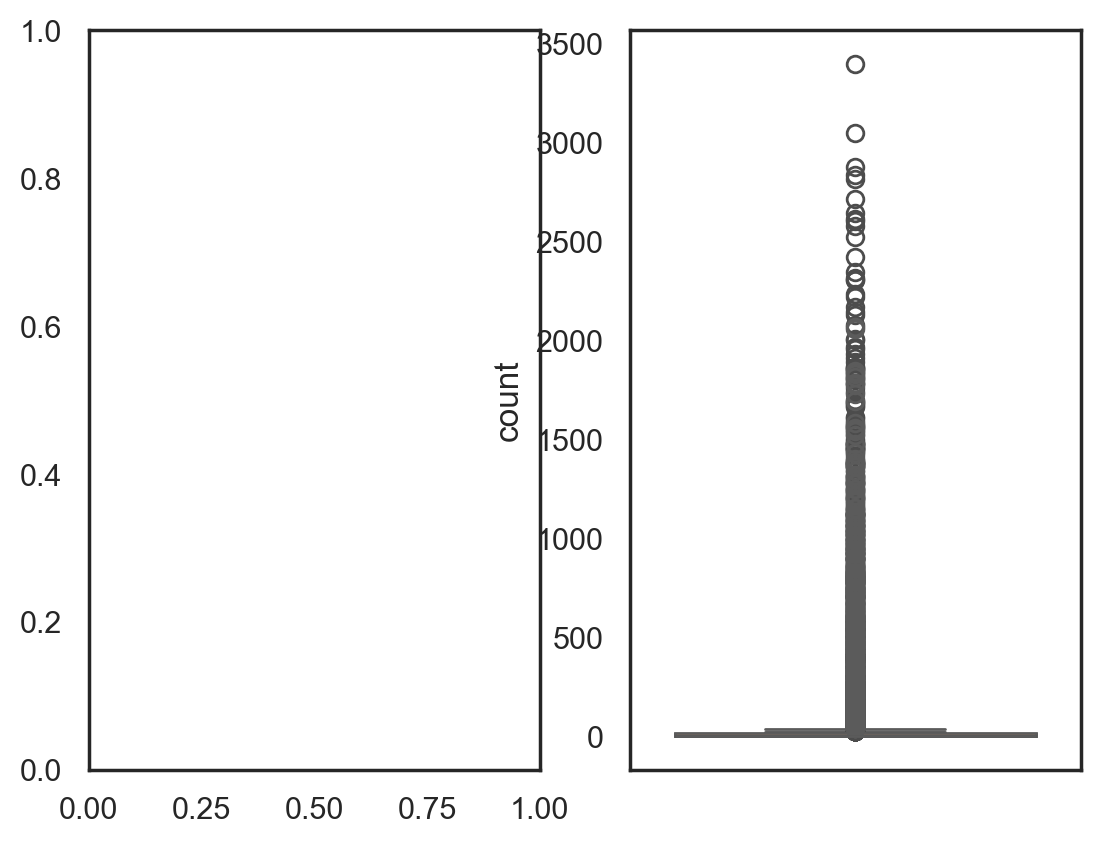

In [217]:
fig, ax = plt.subplots(1,2)
ax[0] = sns.boxplot(rdata_train['Zip Code'].value_counts())
ax[1] = sns.boxplot(rdata_test['Zip Code'].value_counts())
plt.show()

`There's no reason to remove outliers, except for specific models on the most voted areas.`

### District Name

District Name  District Name
count                       574026         387975
unique                           8              8
top                            NYC            NYC
freq                        270779         187972
%_na                      3.276487            0.0
is_actually_numeric          False          False
non numeric mode     (NYC, 270779)  (NYC, 187972)

District Name   STATEWIDE
train outliers       3976
test outliers        2374

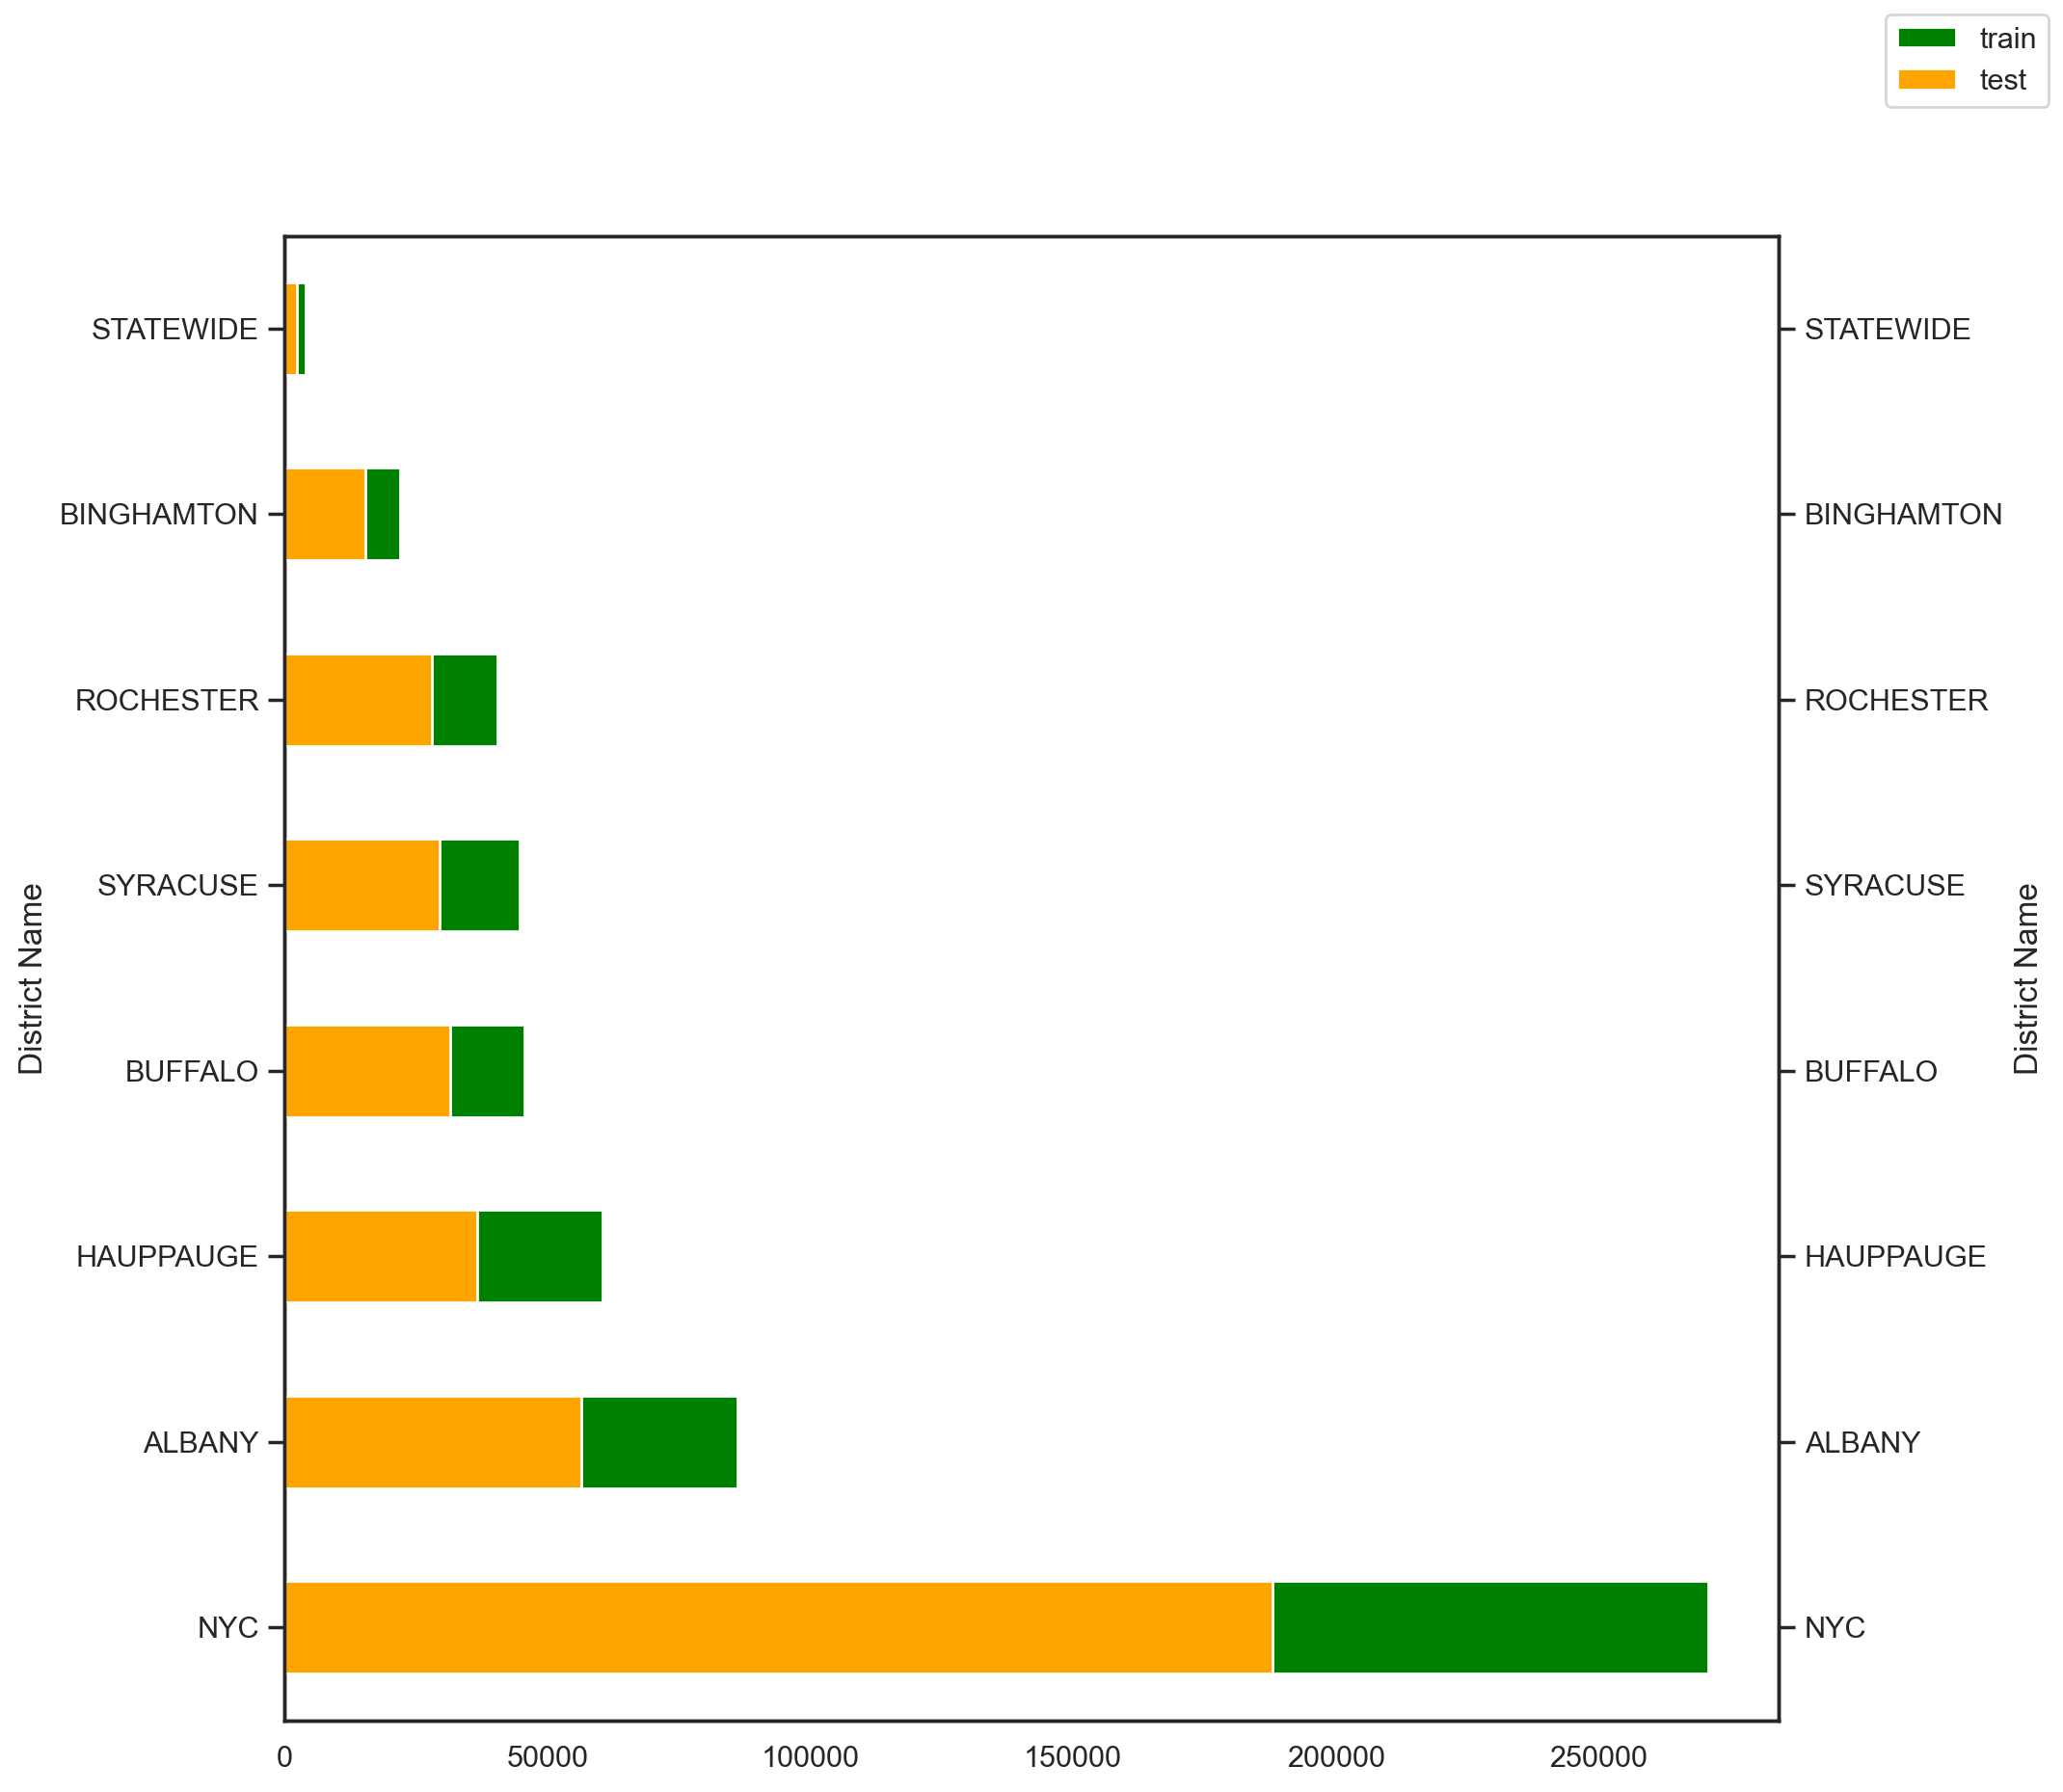

In [219]:
district_name = UnivariateAnalysis('District Name', hist = True)

### Industry Code

Industry Code  Industry Code
count                   564068.0       380239.0
unique                      24.0           24.0
top                         62.0           62.0
freq                    114339.0        72207.0
%_na                    4.954412       1.993943
non numeric mode  (62.0, 114339)  (62.0, 72207)

Industry Code   55.0
train outliers   370
test outliers    294

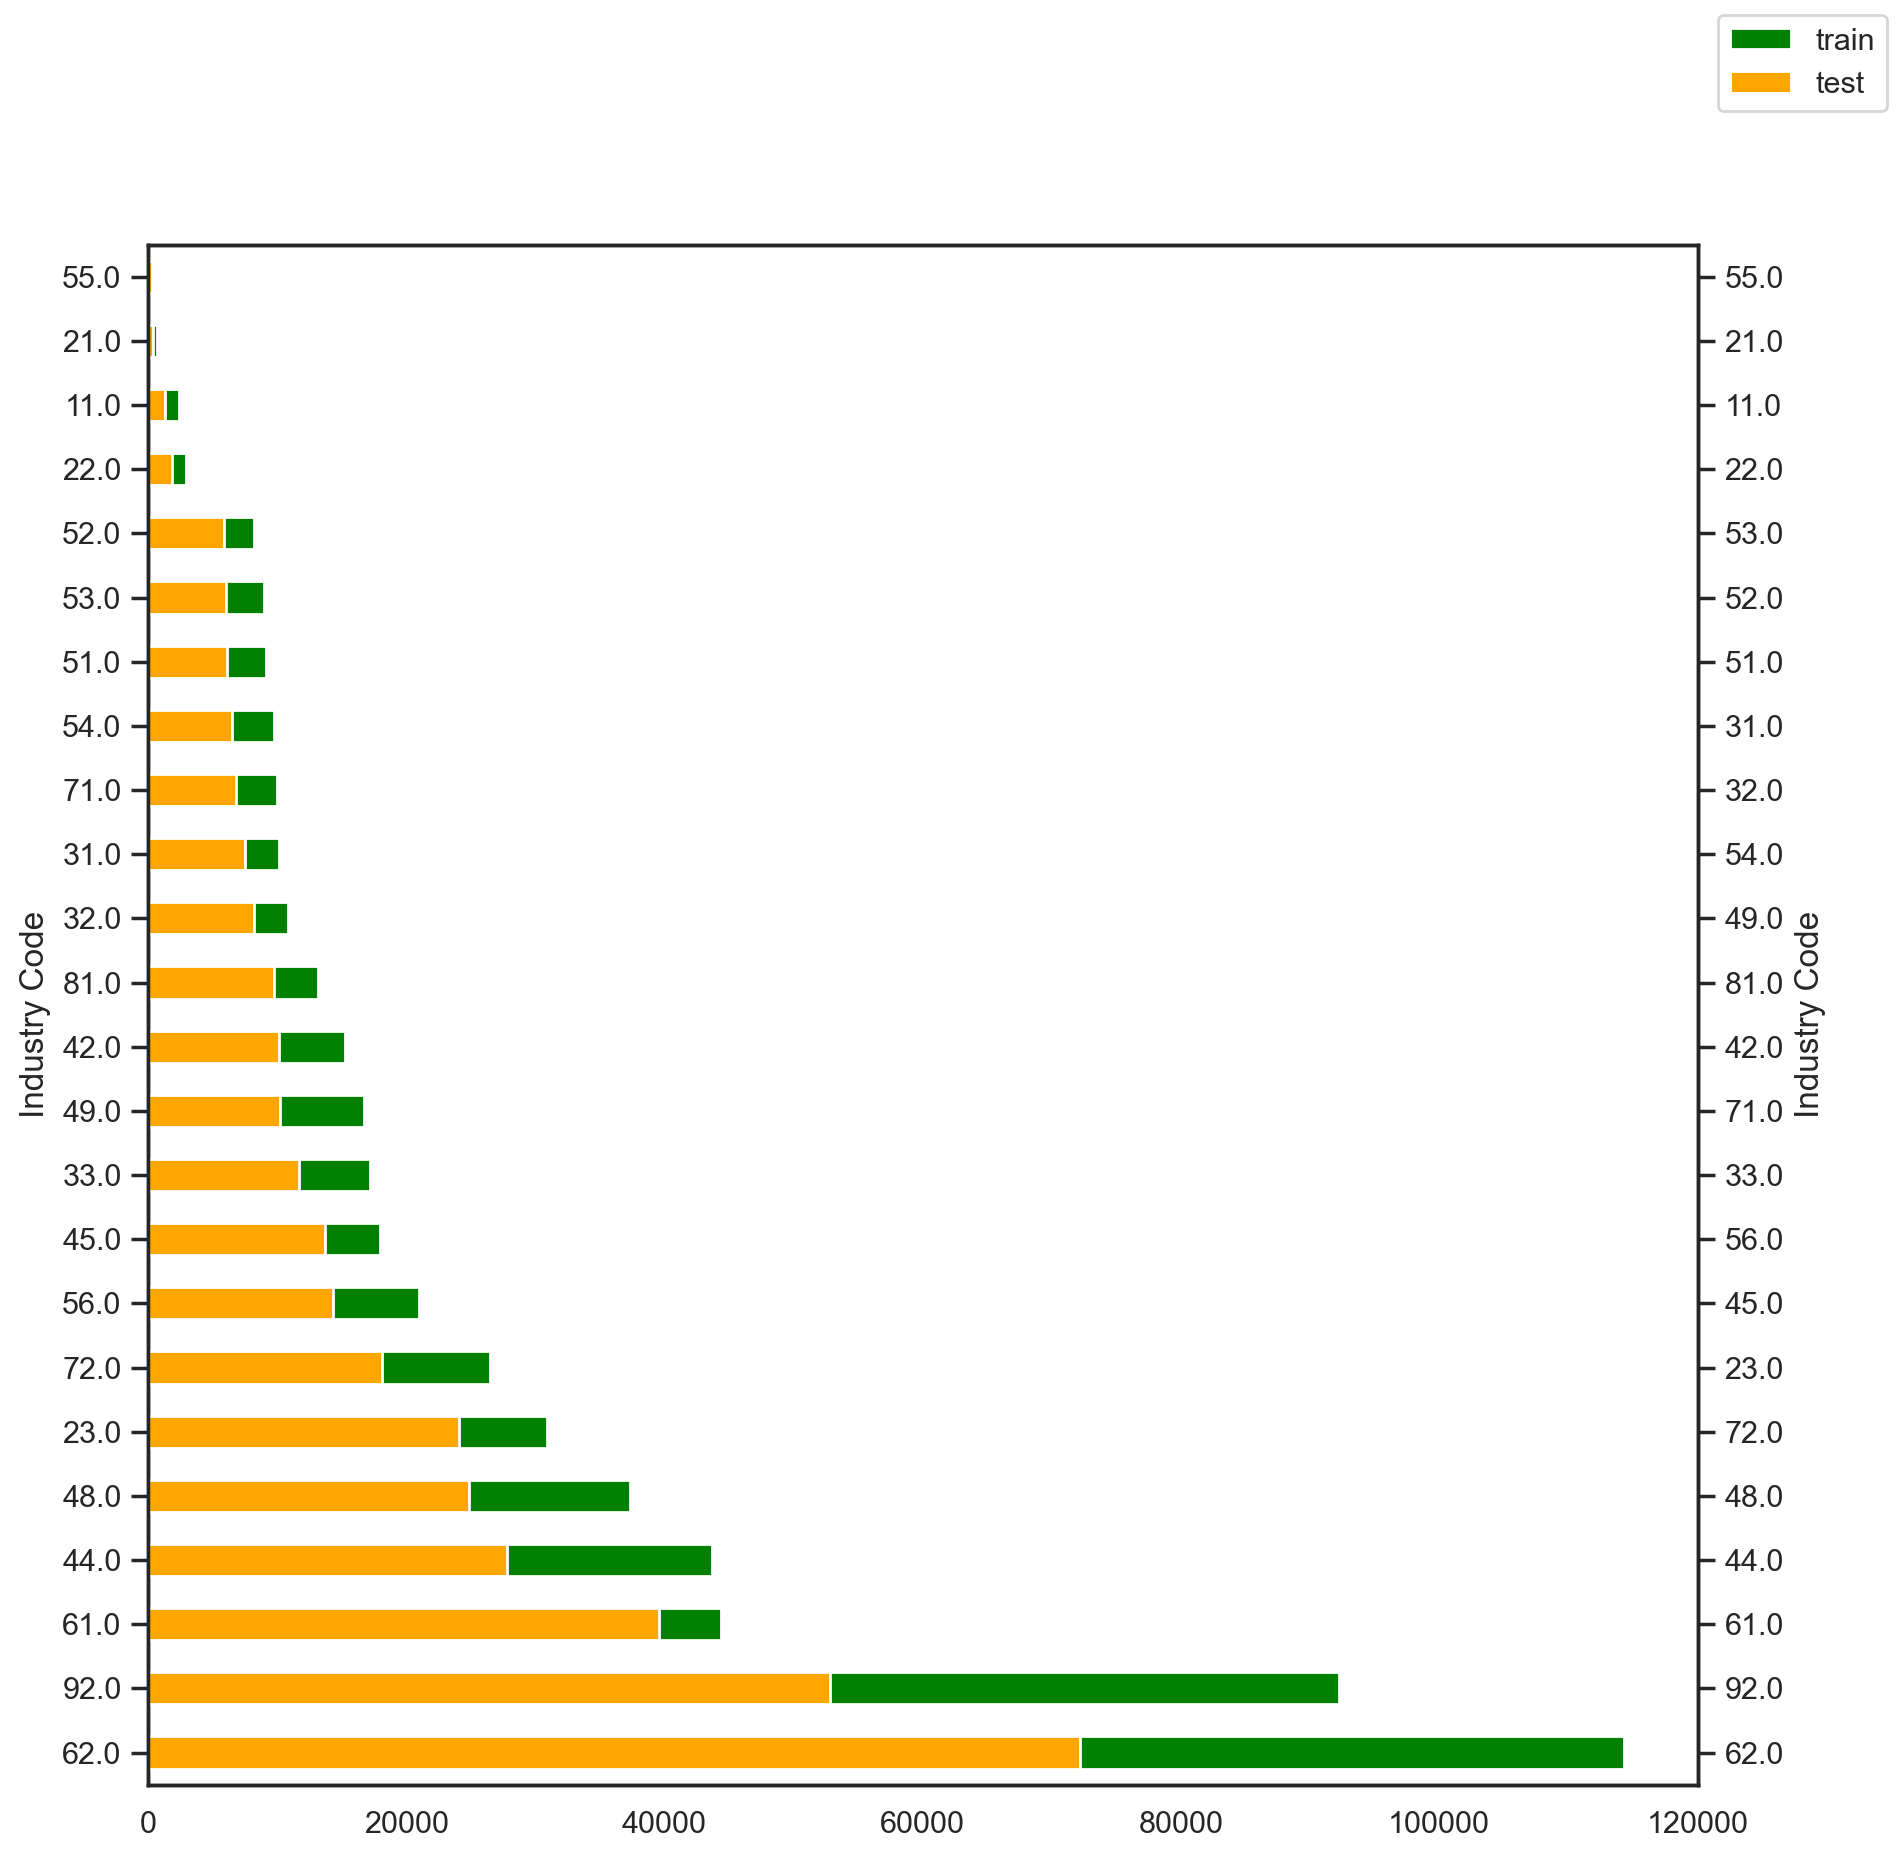

In [396]:
# UnivariateAnalysis(rdata_train['Industry Code'])
col = 'Industry Code'
rdata_train[col] = rdata_train[col].astype('category')
rdata_test[col] = rdata_test[col].astype('category')
n_train = rdata_train[col].shape[0]
n_test = rdata_test[col].shape[0]
    
summary_train = rdata_train[col].describe()
    
na_indexes = rdata_train[col][rdata_train[col].isna()].index
na_quantity = rdata_train[col][na_indexes].shape[0]
na_percentage = na_quantity/n_train
summary_train['%_na'] = na_percentage*100

non_numeric_frequencies = rdata_train[col].value_counts()
summary_train['non numeric mode'] = (non_numeric_frequencies.index[0], non_numeric_frequencies.values[0])

######################à
summary_test = rdata_test[col].describe()
    
na_indexes = rdata_test[col][rdata_test[col].isna()].index
na_quantity = rdata_test[col][na_indexes].shape[0]
na_percentage = na_quantity/n_test
summary_test['%_na'] = na_percentage*100

non_numeric_frequencies = rdata_test[col].value_counts()
summary_test['non numeric mode'] = (non_numeric_frequencies.index[0], non_numeric_frequencies.values[0])

##########################
summary = pd.concat([summary_train, summary_test], axis=1)
display(summary)

limit_train = rdata_train[col].value_counts().iloc[-1]
limit_test = rdata_test[col].value_counts().iloc[-1]
outl = pd.DataFrame({
        'train outliers': rdata_train[col].value_counts()[rdata_train[col].value_counts() == limit_train],
        'test outliers': rdata_test[col].value_counts()[rdata_test[col].value_counts() == limit_test]
            }).T
display(outl)

fig, axs = plt.subplots(figsize=(10,10))
axs = rdata_train[col].value_counts().sort_values(ascending=False).plot(kind='barh', color='green', label='train');
axs2 = axs.twinx() 
axs2 = rdata_test[col].value_counts().sort_values(ascending=False).plot(kind='barh', color='orange', label='test');   
fig.legend()
plt.savefig('{0}_barplot'.format(col))
plt.show()

In [400]:
print(summary.to_latex())
print(outl.to_latex())

\begin{tabular}{lll}
\toprule
 & Industry Code & Industry Code \\
\midrule
count & 564068.000000 & 380239.000000 \\
unique & 24.000000 & 24.000000 \\
top & 62.000000 & 62.000000 \\
freq & 114339.000000 & 72207.000000 \\
%_na & 4.954412 & 1.993943 \\
non numeric mode & (62.0, 114339) & (62.0, 72207) \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
Industry Code & 55.000000 \\
\midrule
train outliers & 370 \\
test outliers & 294 \\
\bottomrule
\end{tabular}



### Industry Code Description

Industry Code Description  \
count                                                     564068   
unique                                                        20   
top                            HEALTH CARE AND SOCIAL ASSISTANCE   
freq                                                      114339   
%_na                                                    4.954412   
is_actually_numeric                                        False   
non numeric mode     (HEALTH CARE AND SOCIAL ASSISTANCE, 114339)   

                                      Industry Code Description  
count                                                    380239  
unique                                                       20  
top                           HEALTH CARE AND SOCIAL ASSISTANCE  
freq                                                      72207  
%_na                                                   1.993943  
is_actually_numeric                                       False  
non numeric mode     (HEALTH CARE AND SOCIAL ASSISTANCE, 72207)

Industry Code Description  MANAGEMENT OF COMPANIES AND ENTERPRISES
train outliers                                                 370
test outliers                                                  294

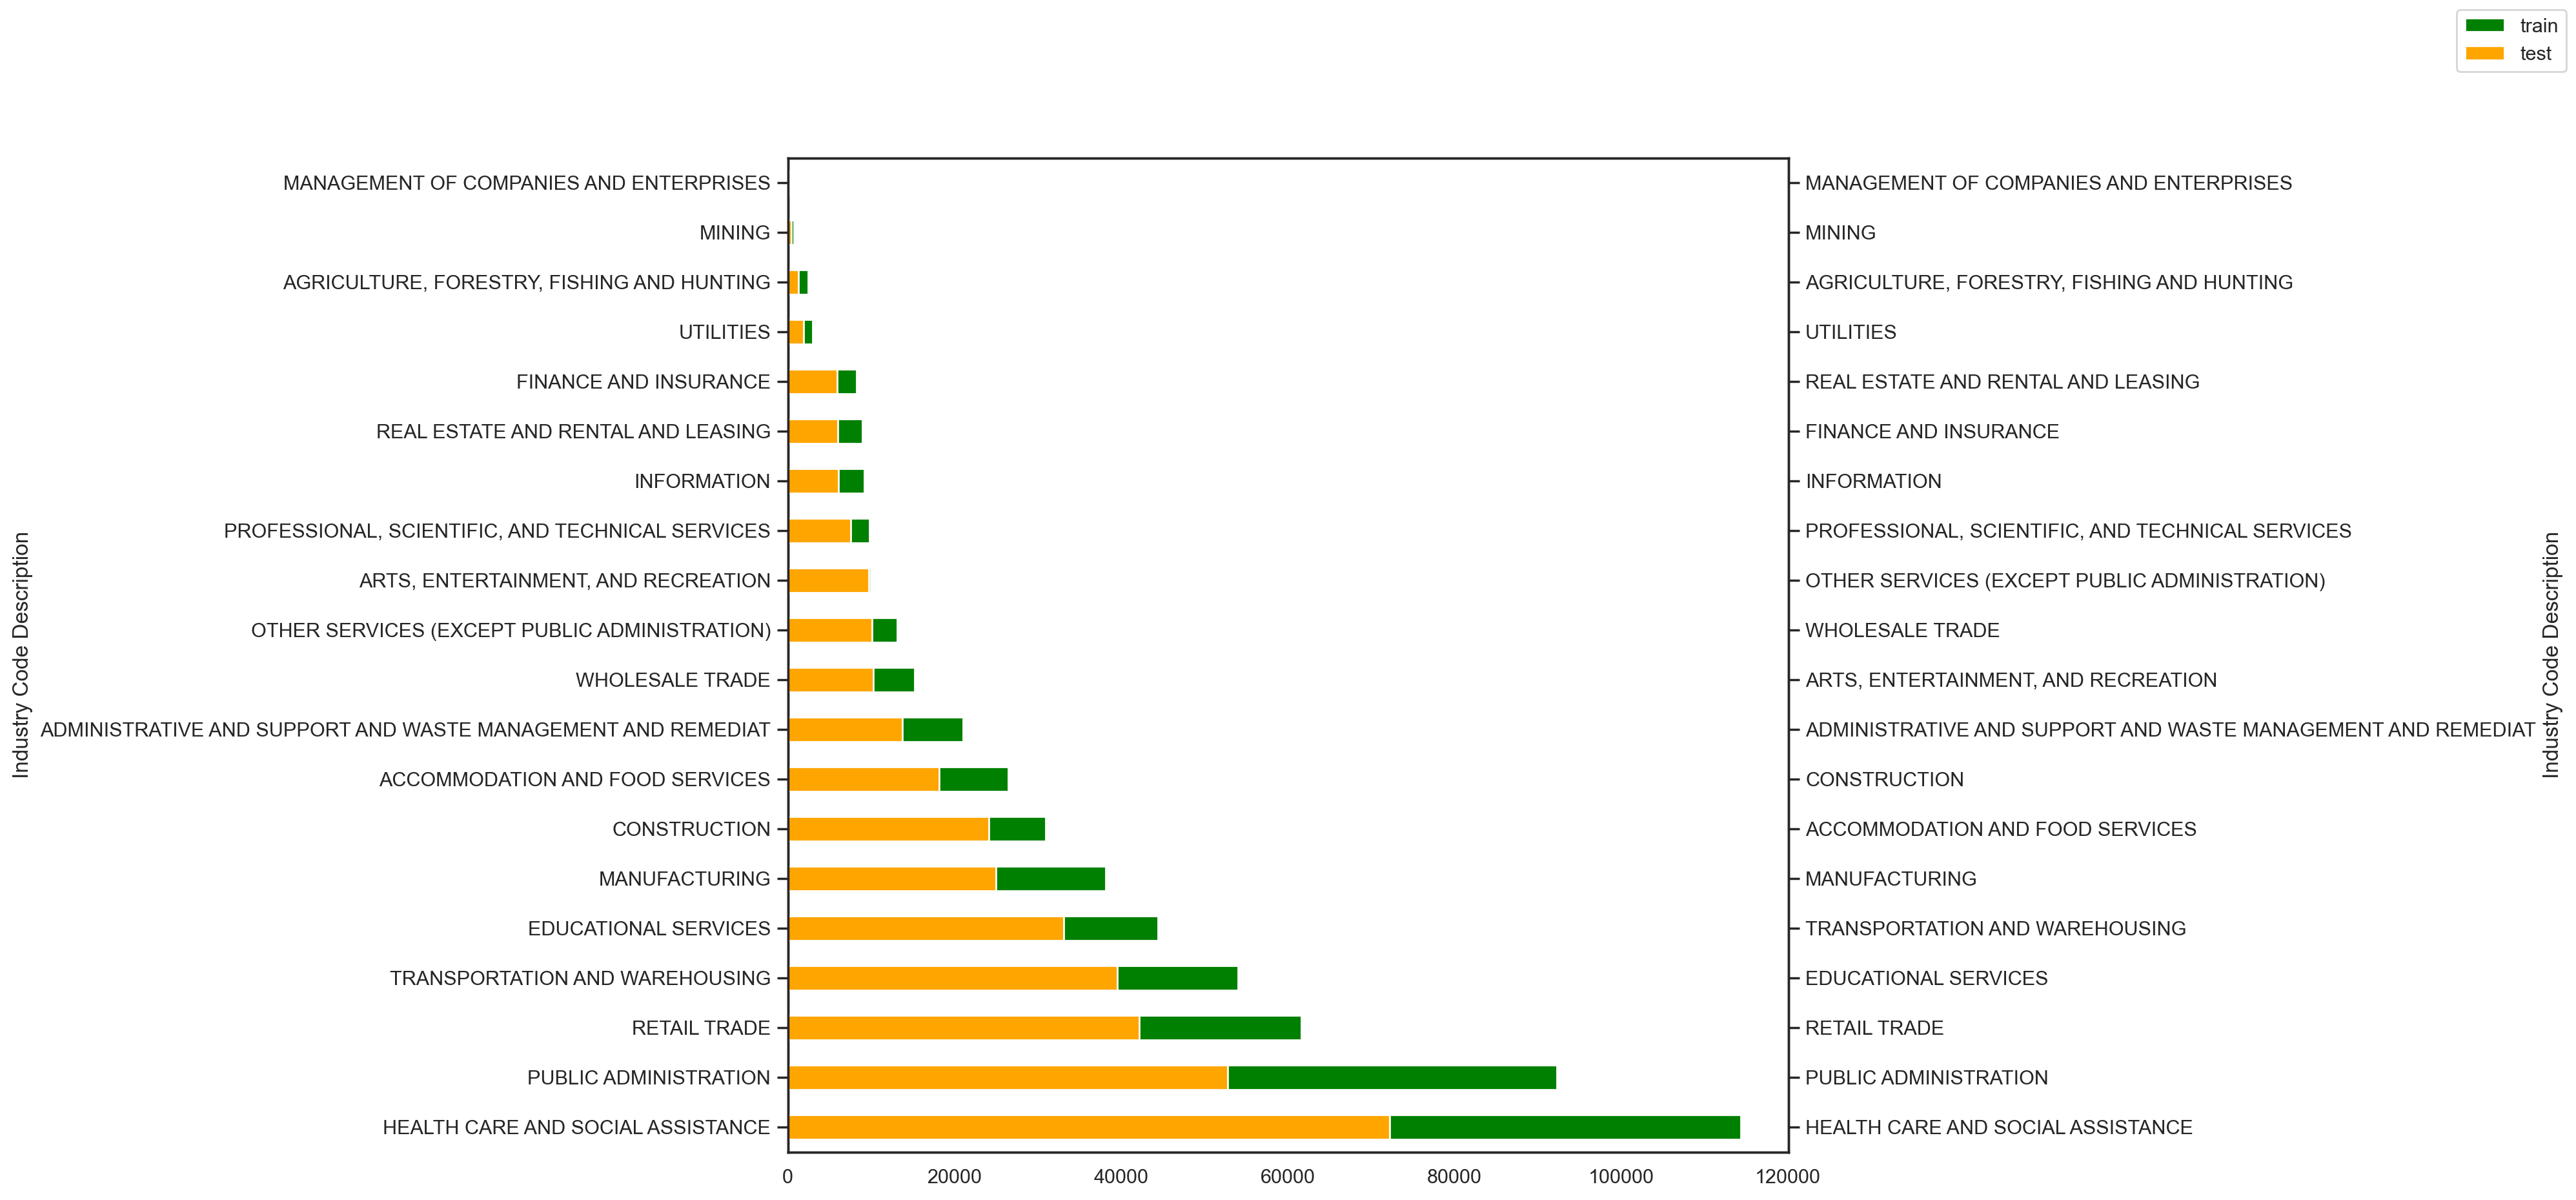

In [235]:
industry_code_description = UnivariateAnalysis('Industry Code Description', hist=True)

`Is there a relationship between Industry Code and Industry description?`
<br> `If so, we can fill NAN with the corresponding values. We'll figure it out in Part2`

### Medical Fee Region

Medical Fee Region Medical Fee Region
count                           574026             387975
unique                               5                  5
top                                 IV                 IV
freq                            265981             182276
%_na                          3.276487                0.0
is_actually_numeric              False              False
non numeric mode          (IV, 265981)       (IV, 182276)

Medical Fee Region     UK
train outliers      33473
test outliers       20977

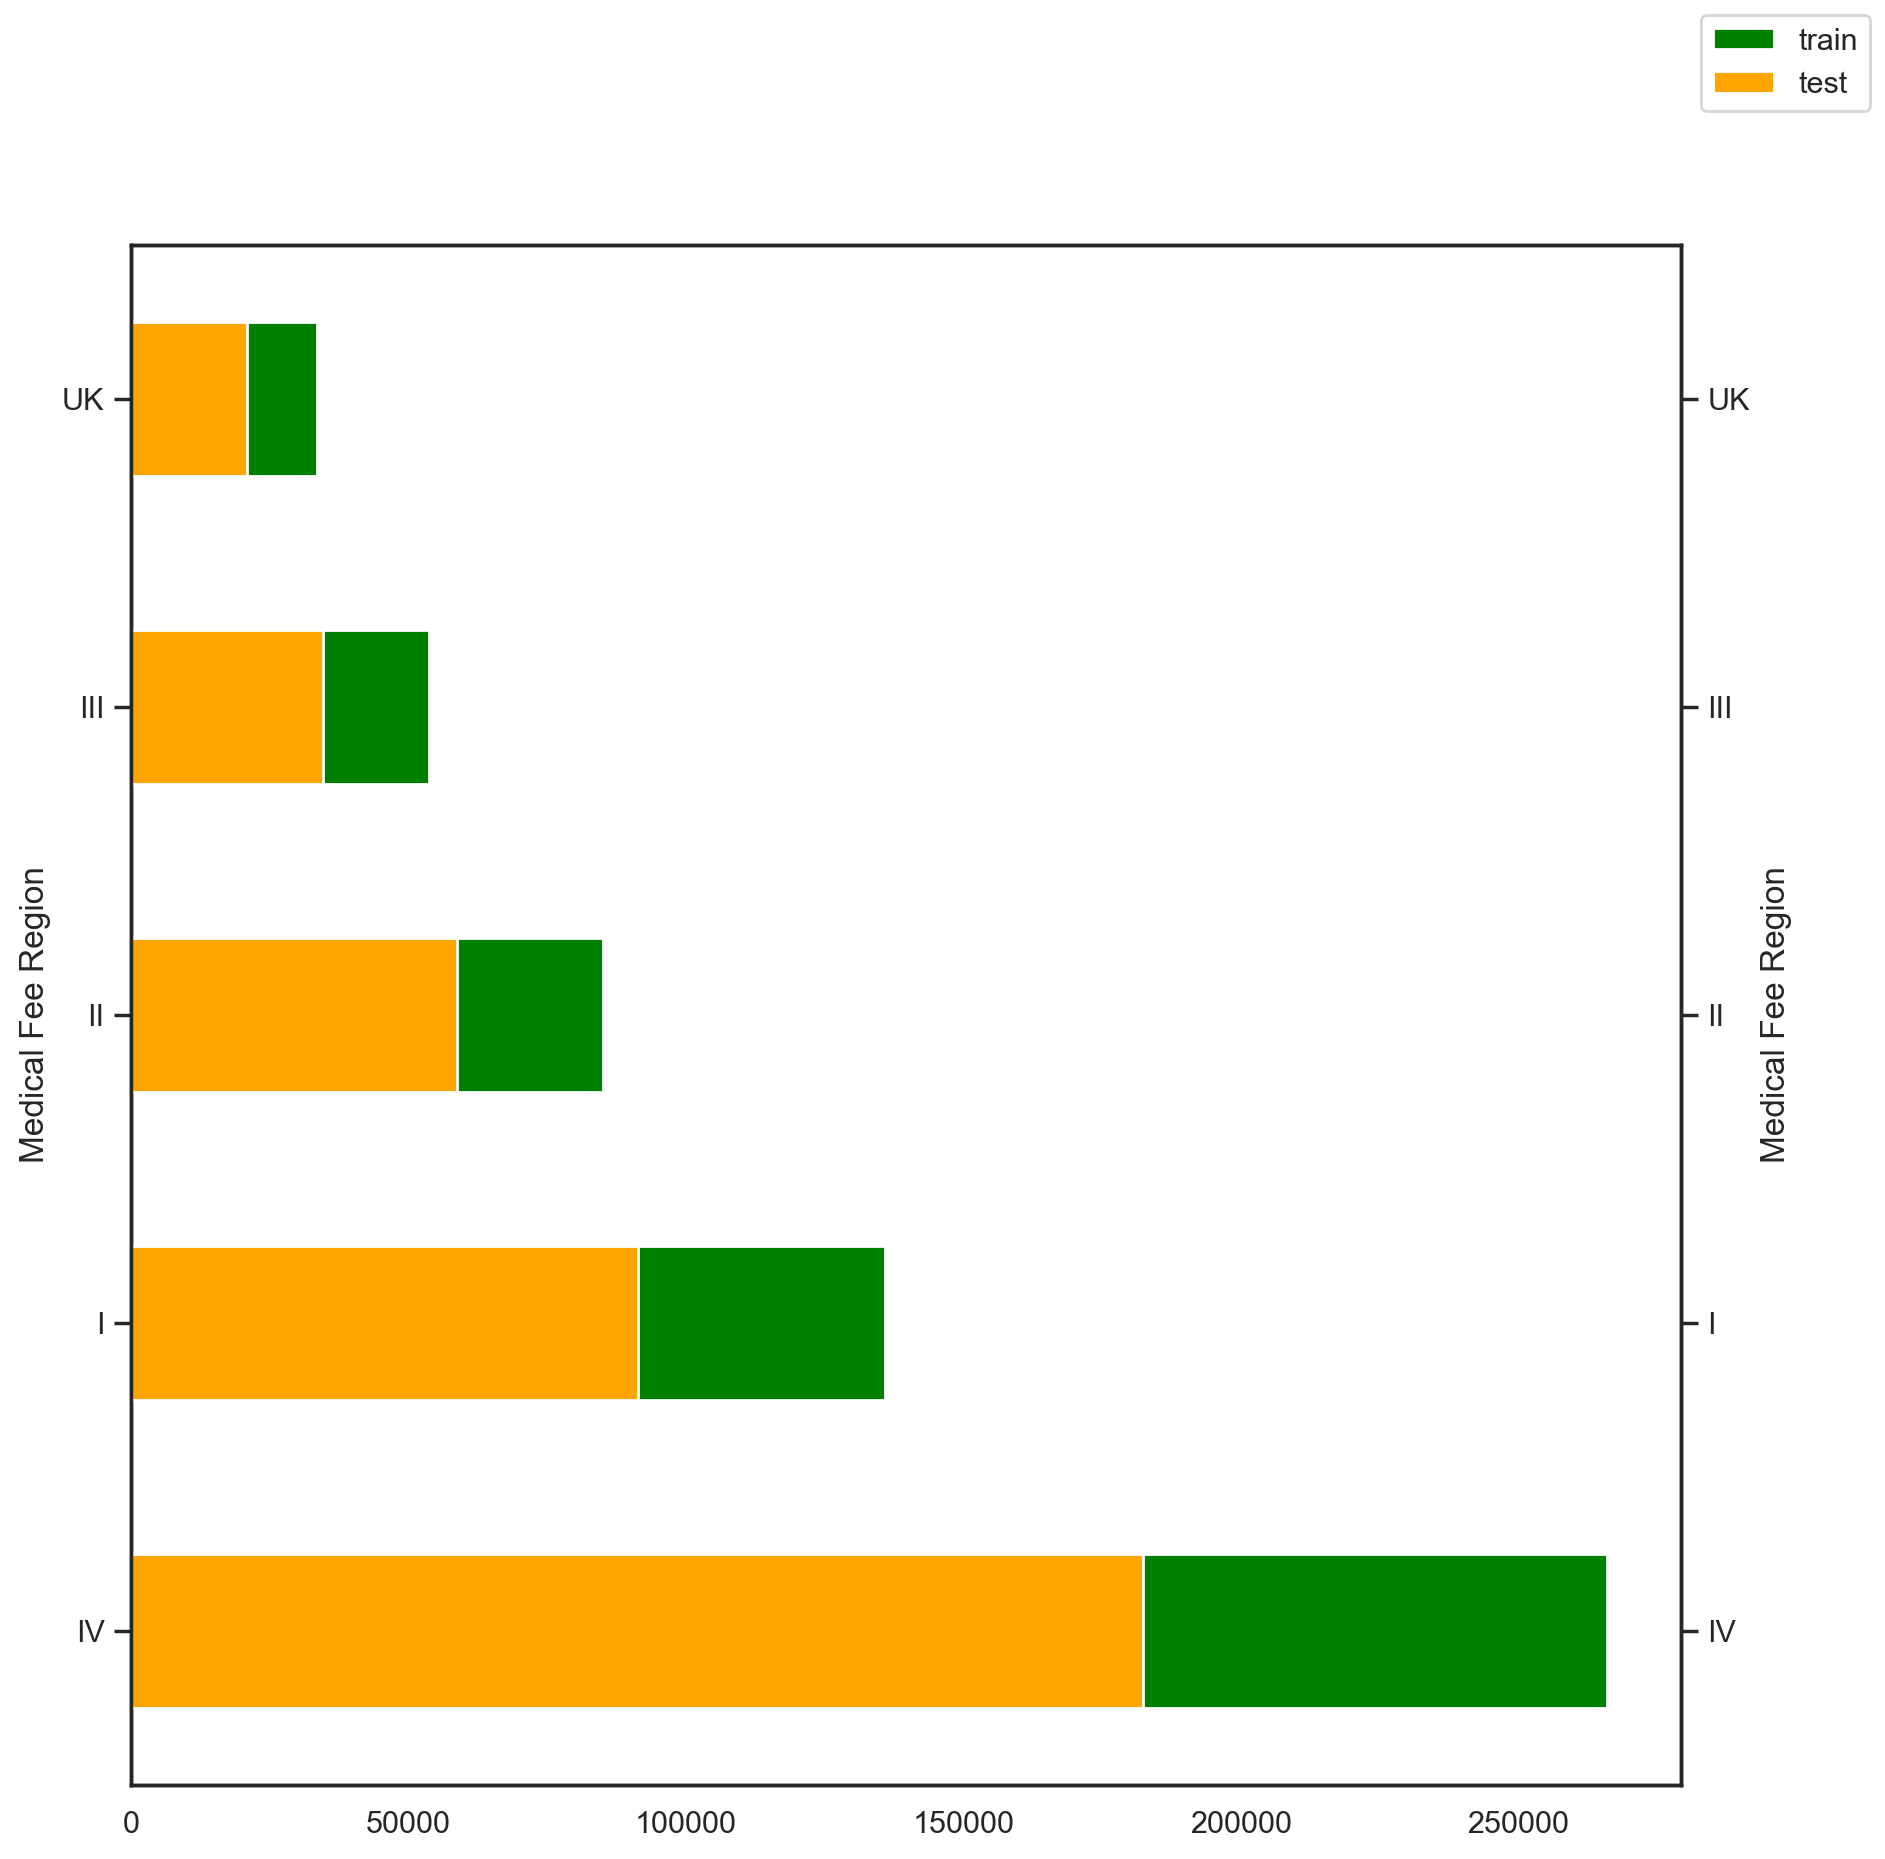

In [237]:
Medical_fee_region = UnivariateAnalysis('Medical Fee Region', hist=True)

### County of Injury

County of Injury County of Injury
count                          574026           387975
unique                             63               63
top                           SUFFOLK           QUEENS
freq                            60430            40358
%_na                         3.276487              0.0
is_actually_numeric             False            False
non numeric mode     (SUFFOLK, 60430)  (QUEENS, 40358)

County of Injury  HAMILTON
train outliers         134
test outliers           97

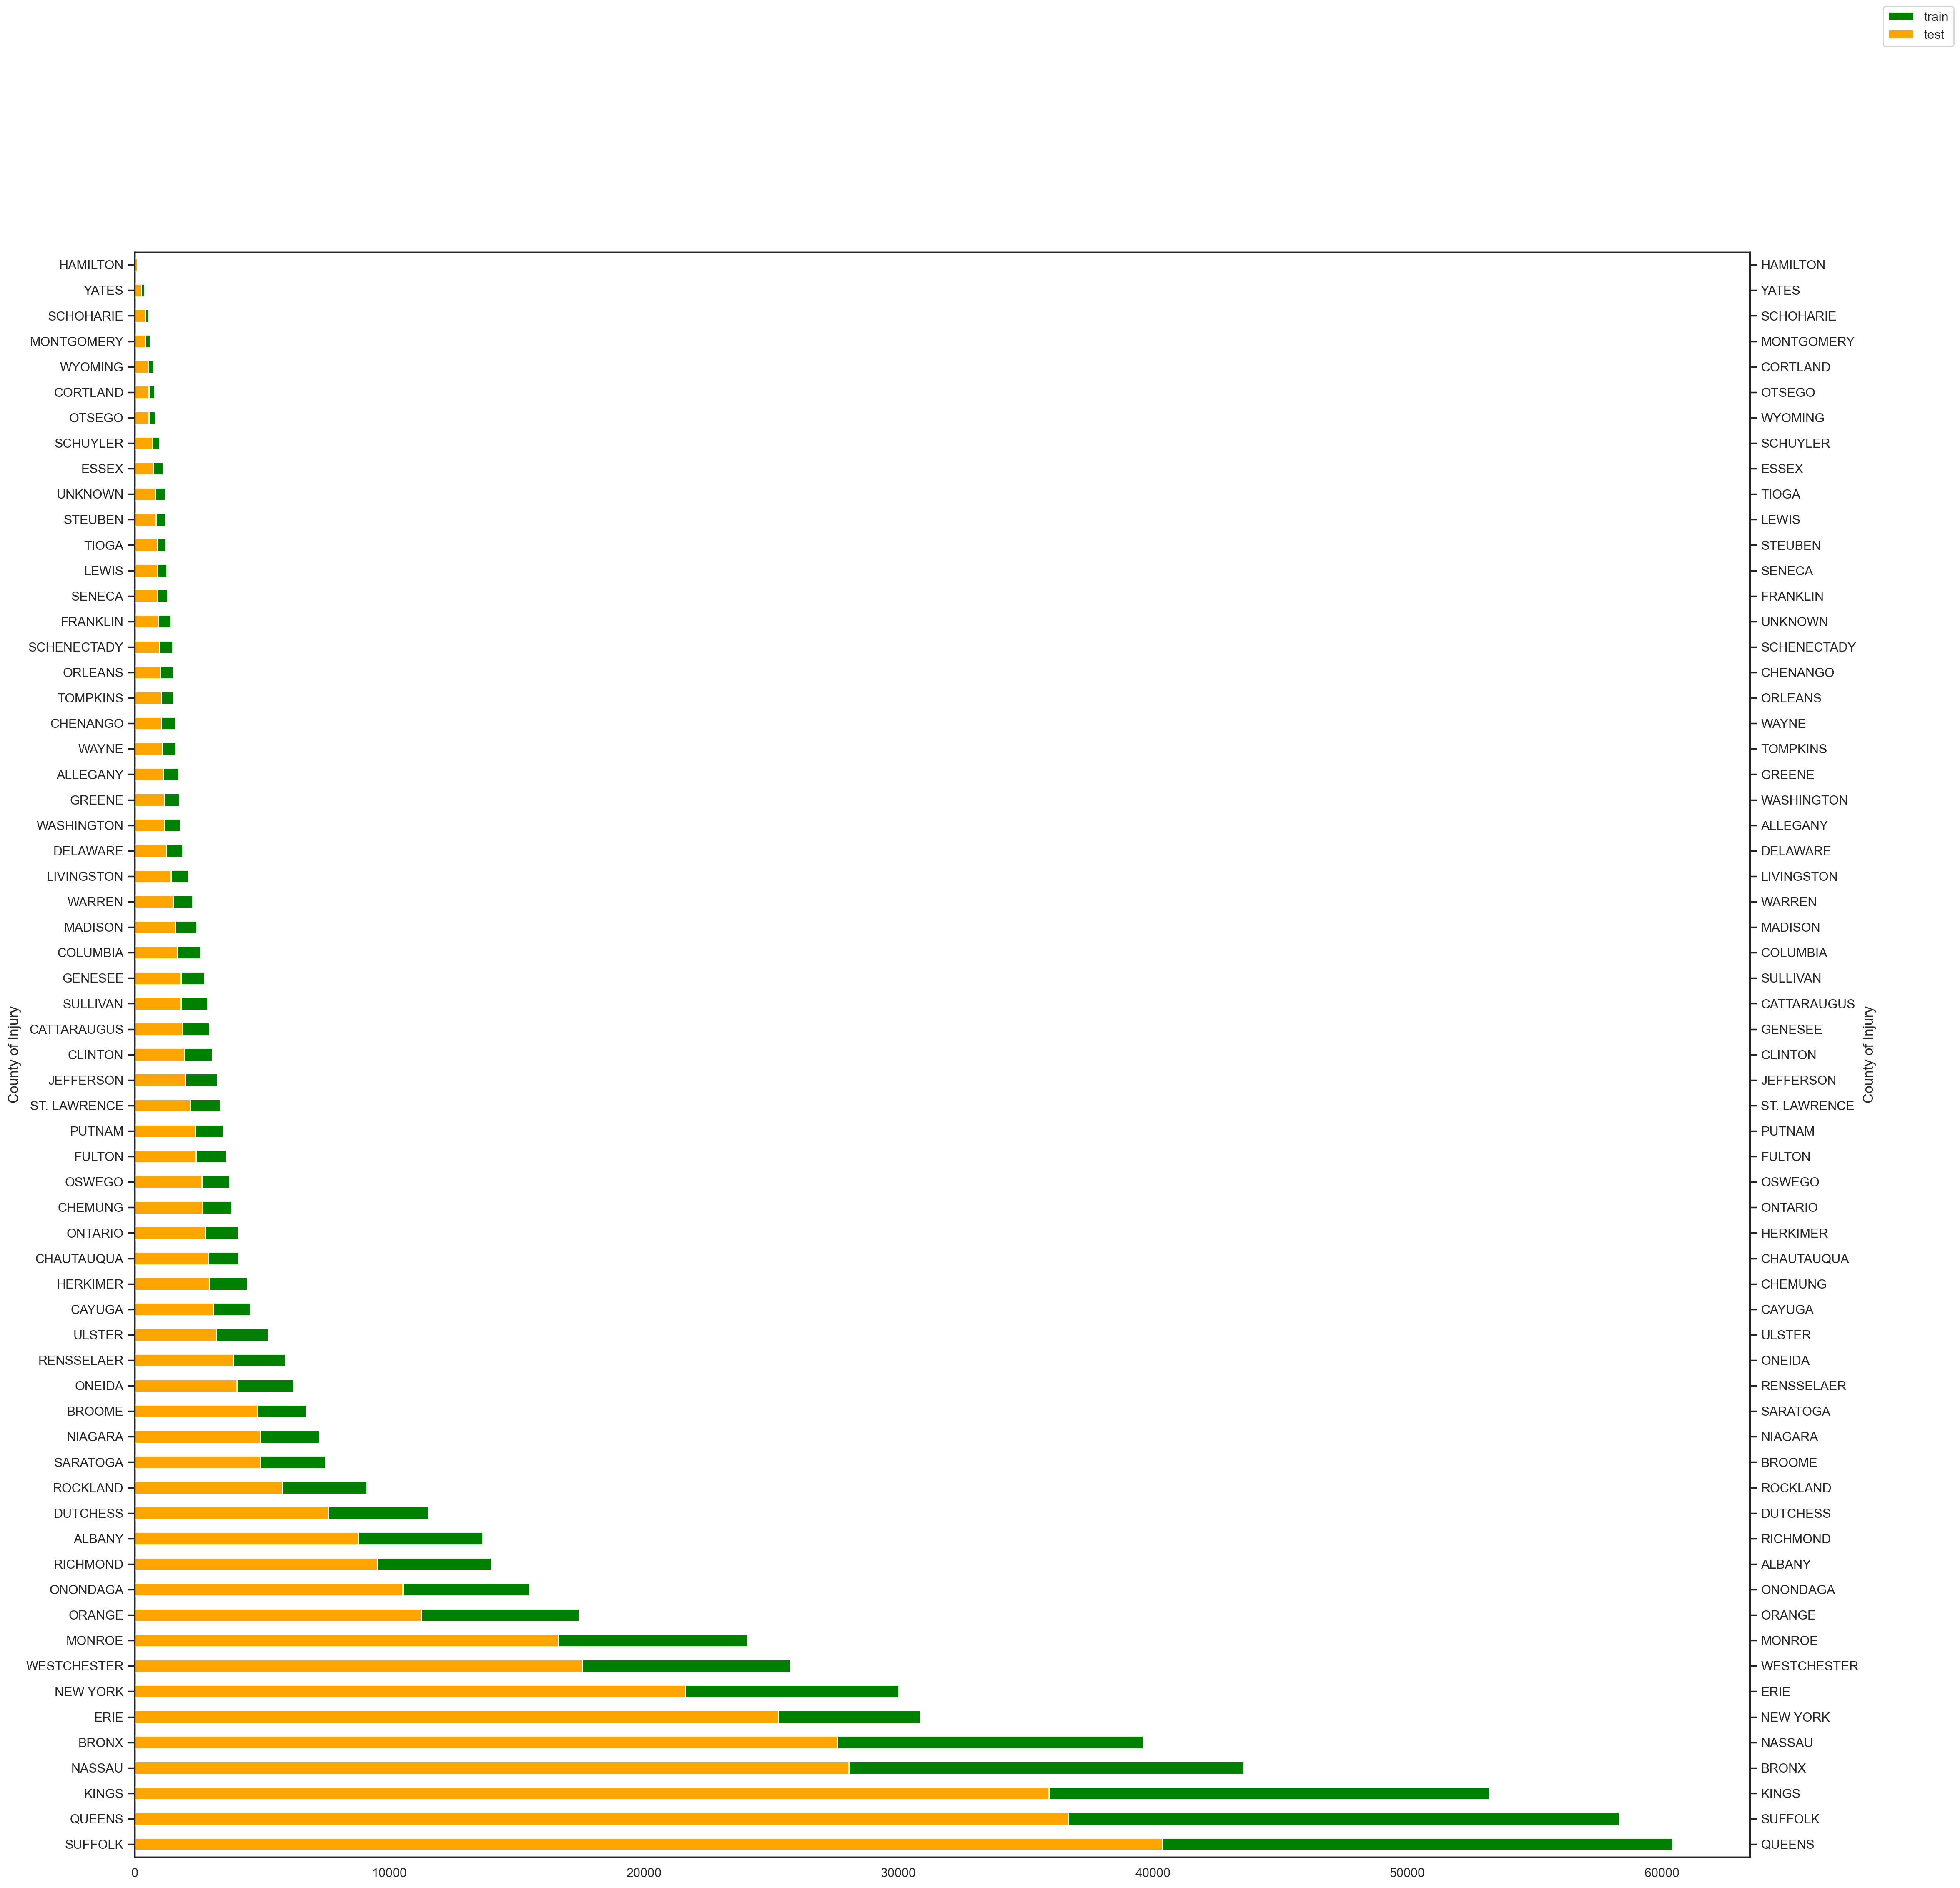

In [239]:
county_of_injury = UnivariateAnalysis('County of Injury', hist=True, figsize=(25,25))

# **Part 2:** Analyse multivariate relationships
To do:
- pair scatterplots
- pearson correlation x spearman correlation
- cramer correlation for cathegorical data

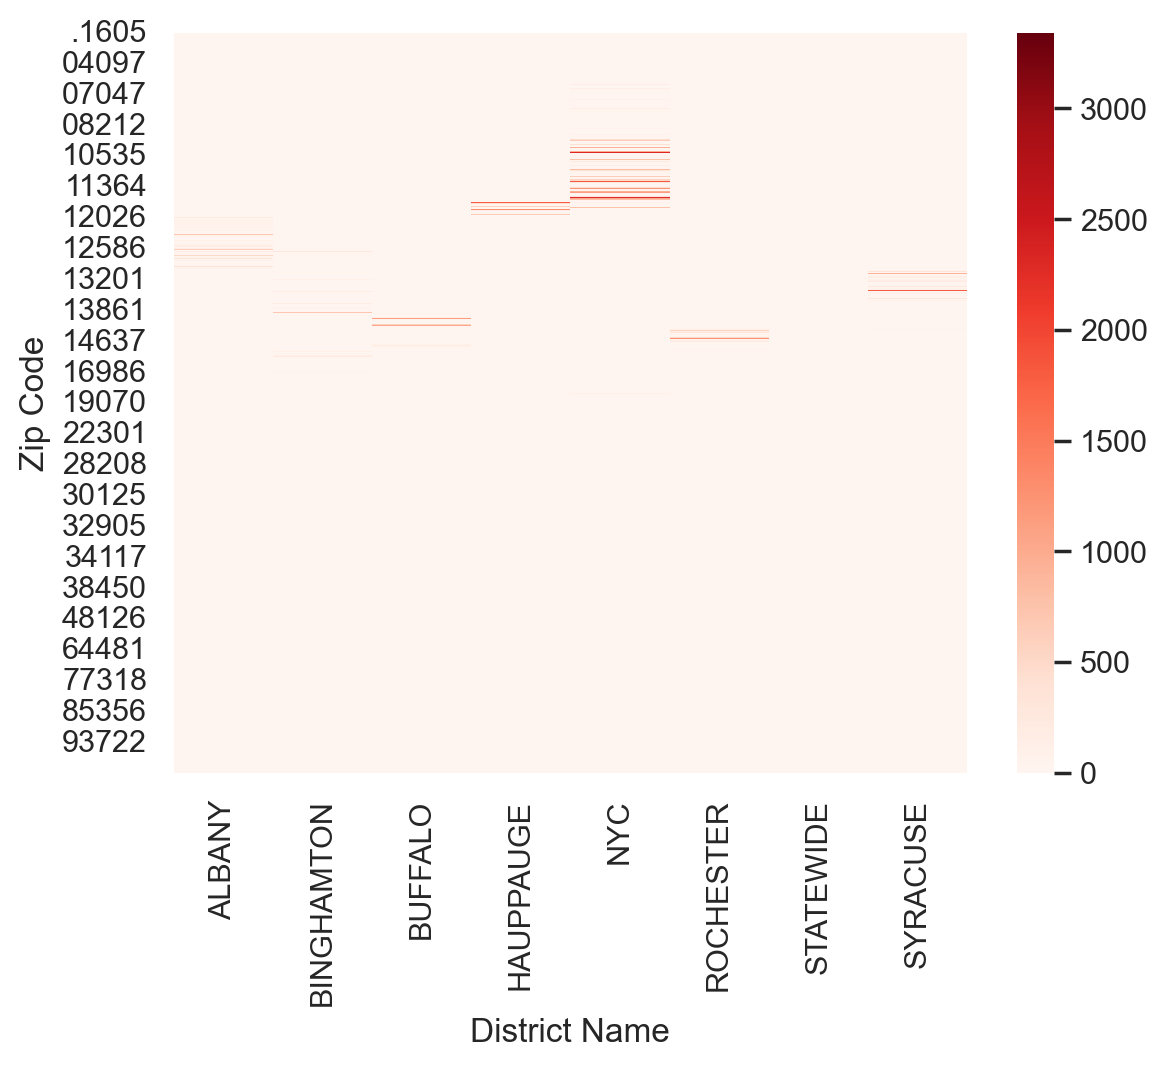

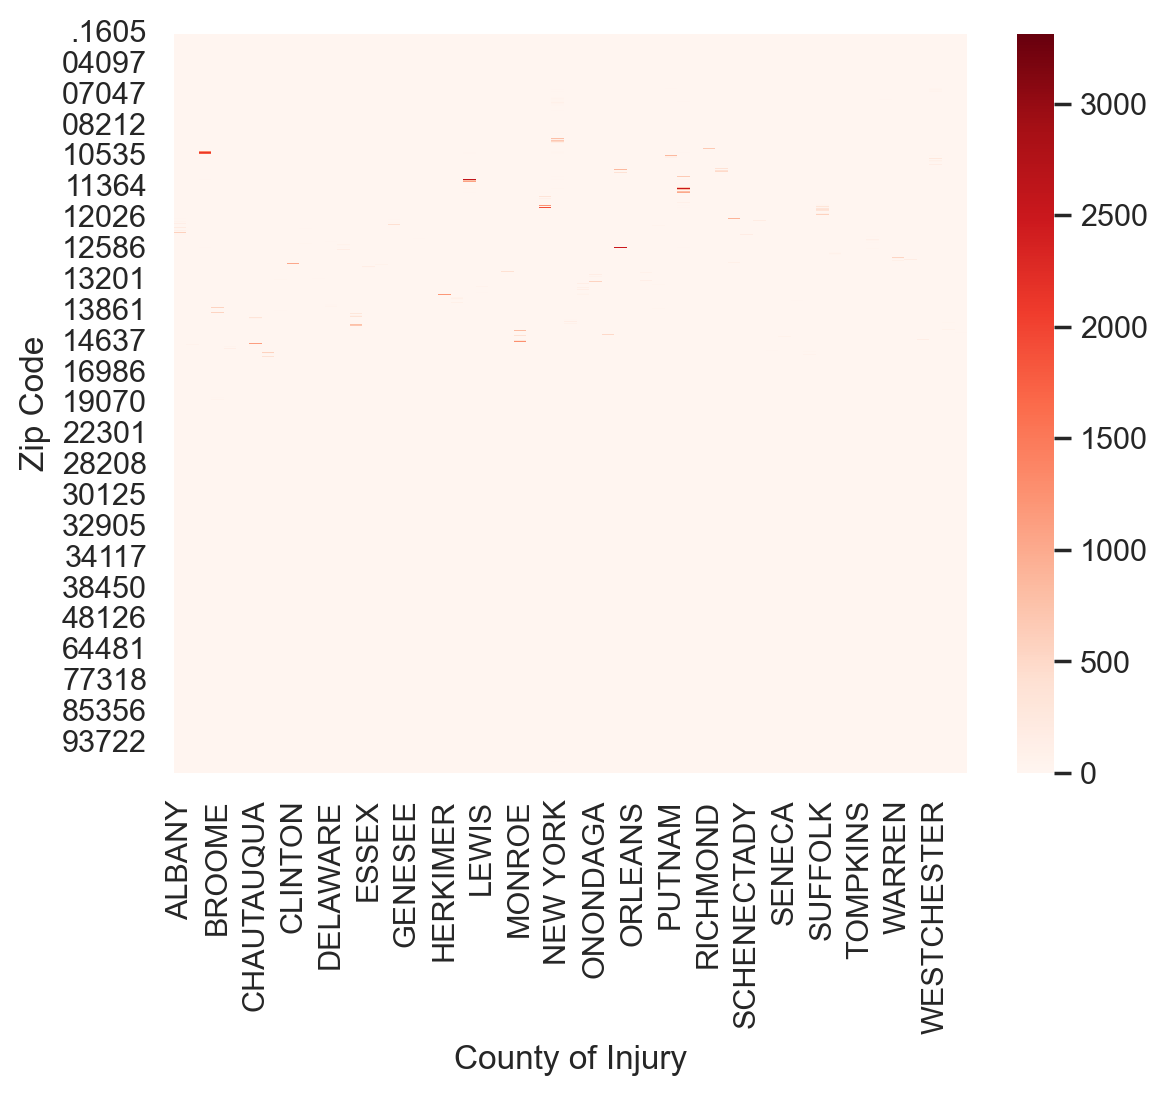

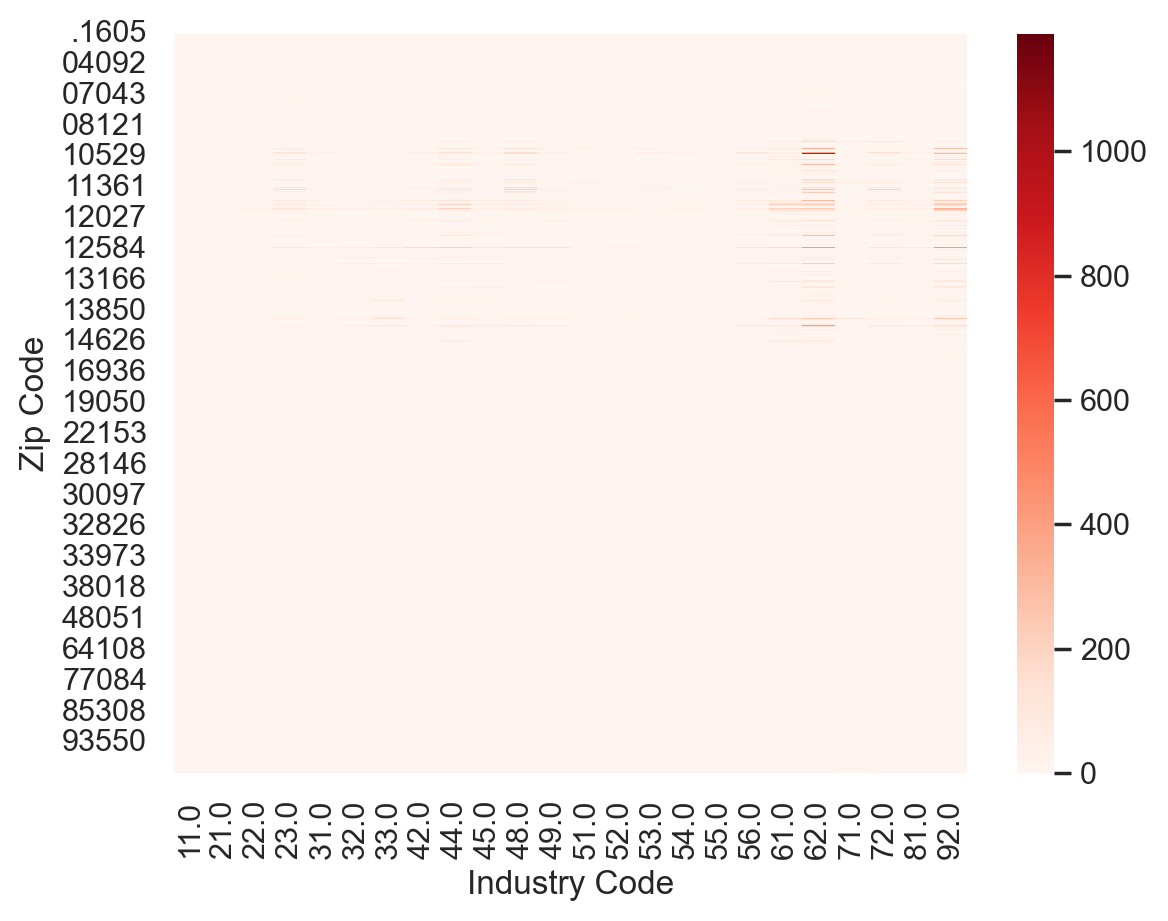

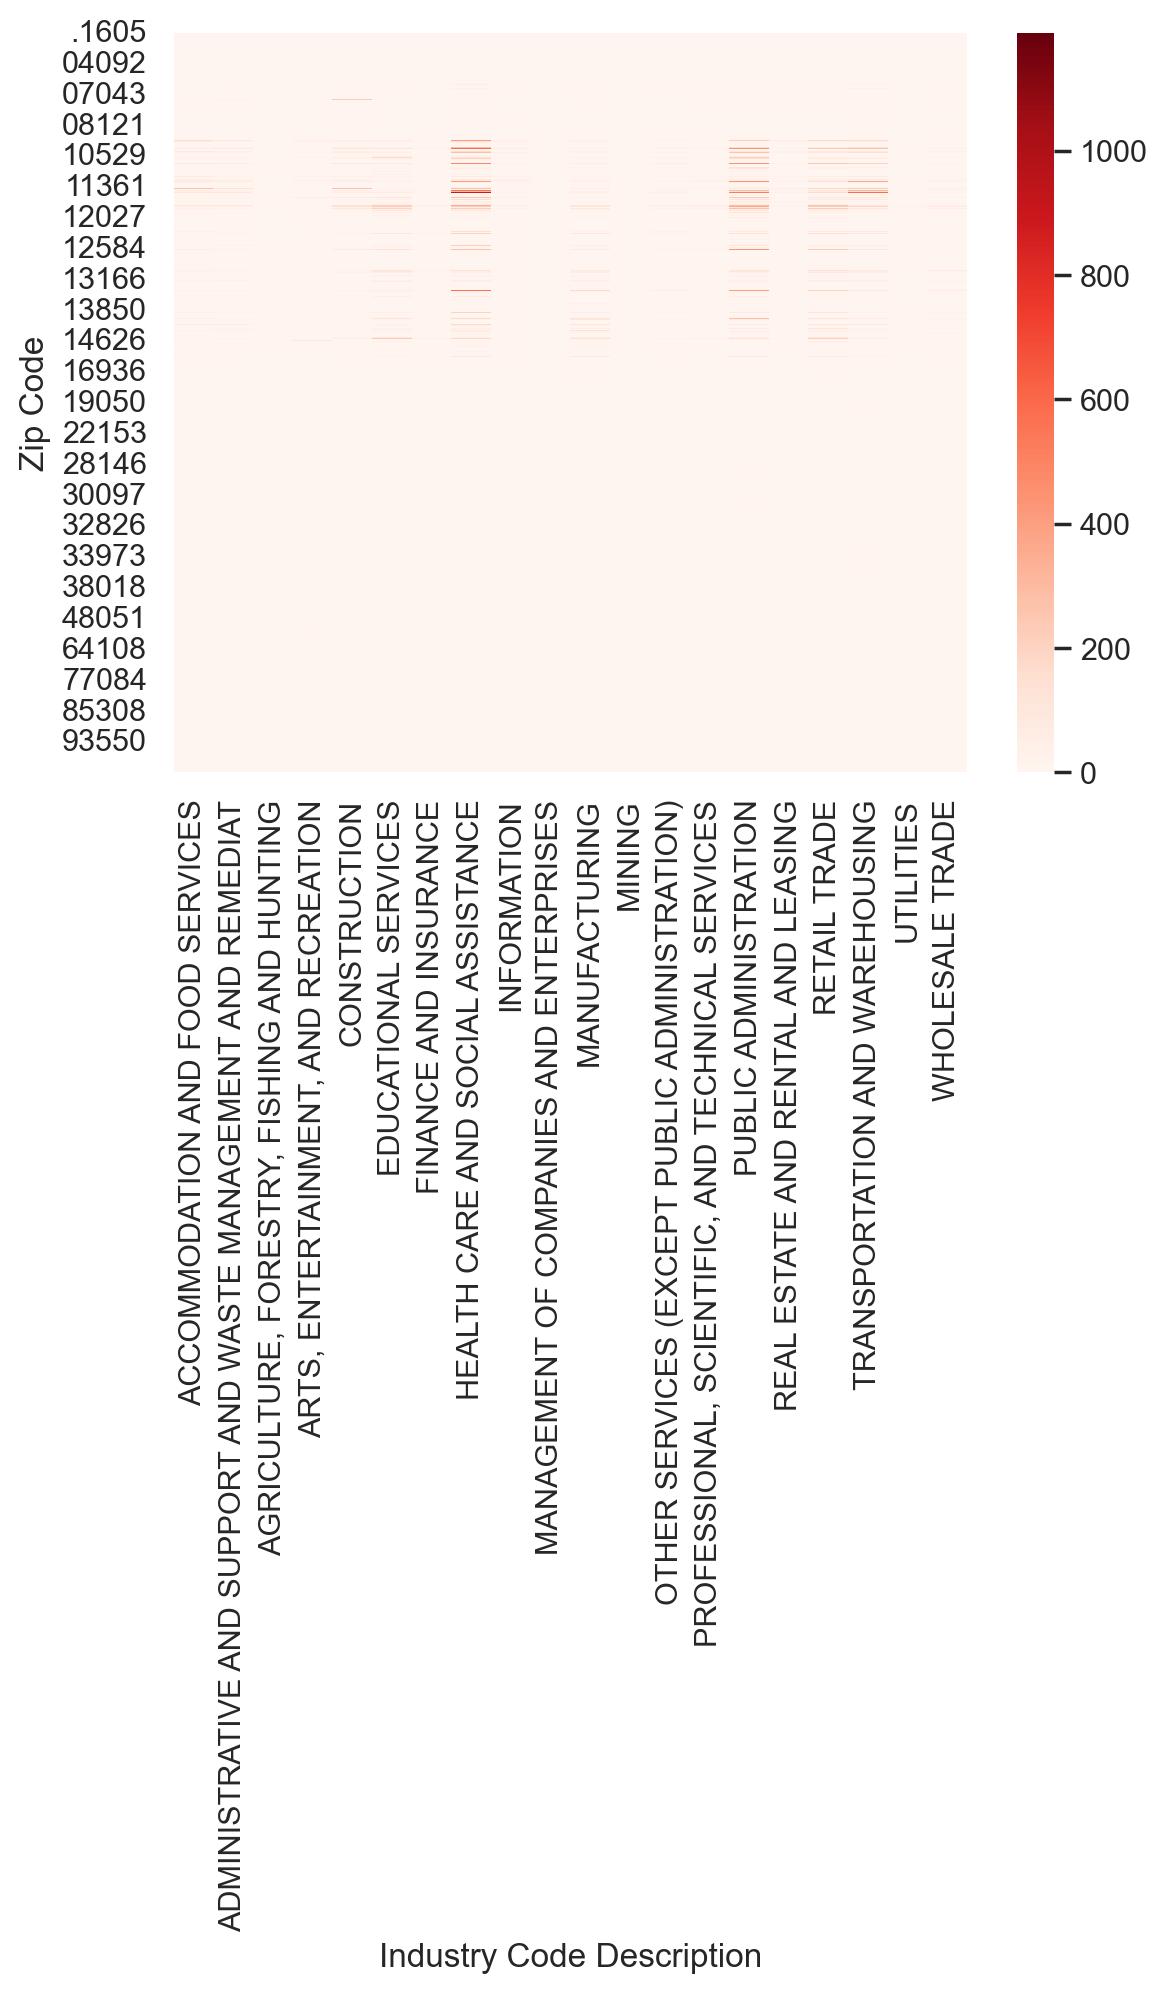

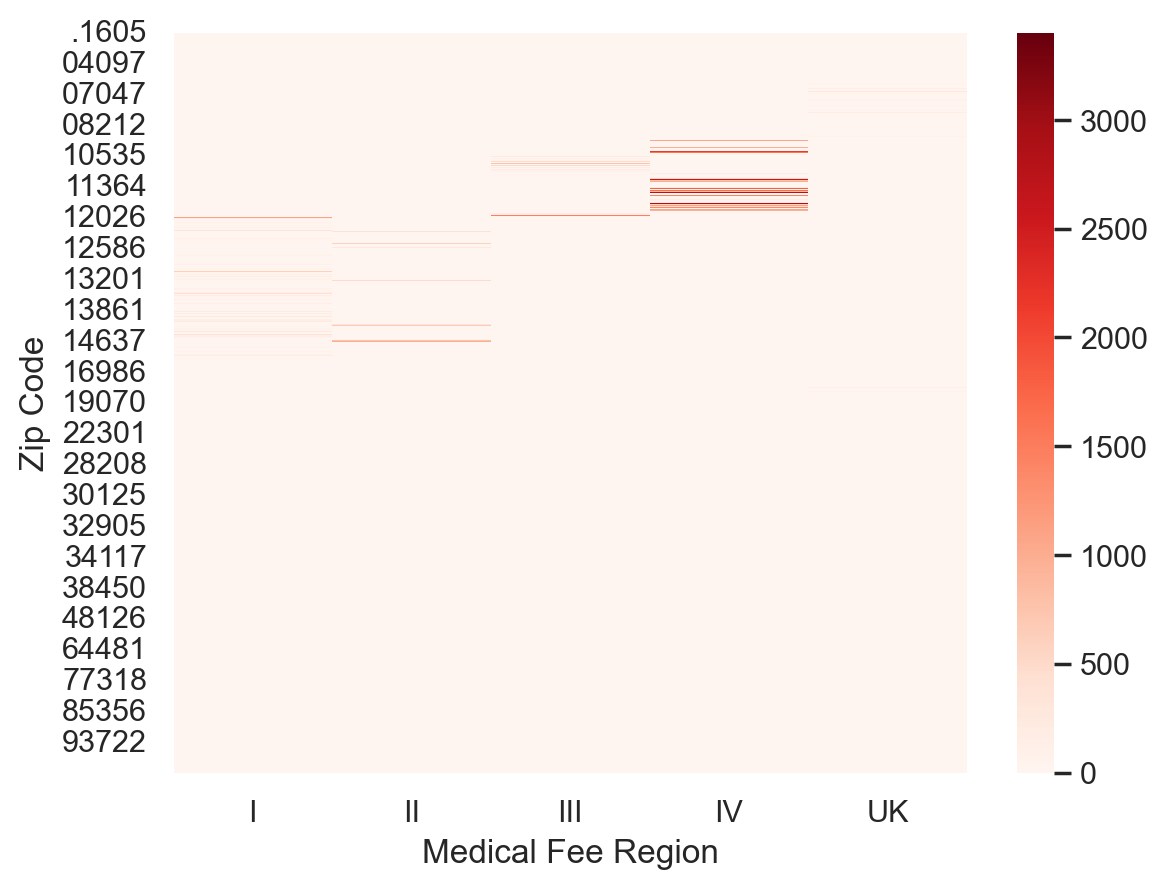

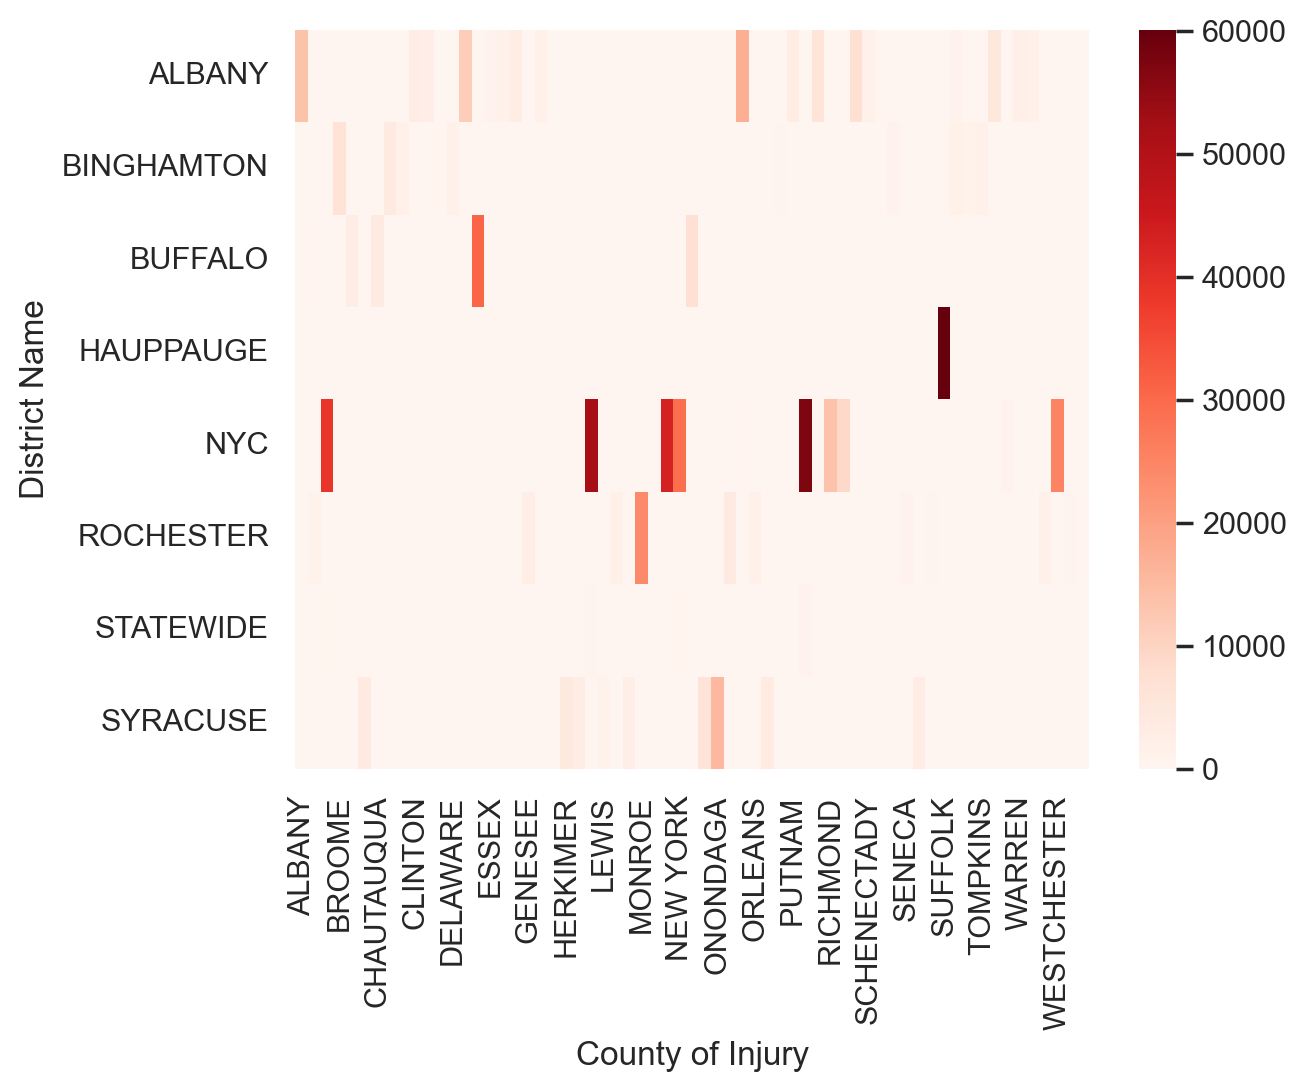

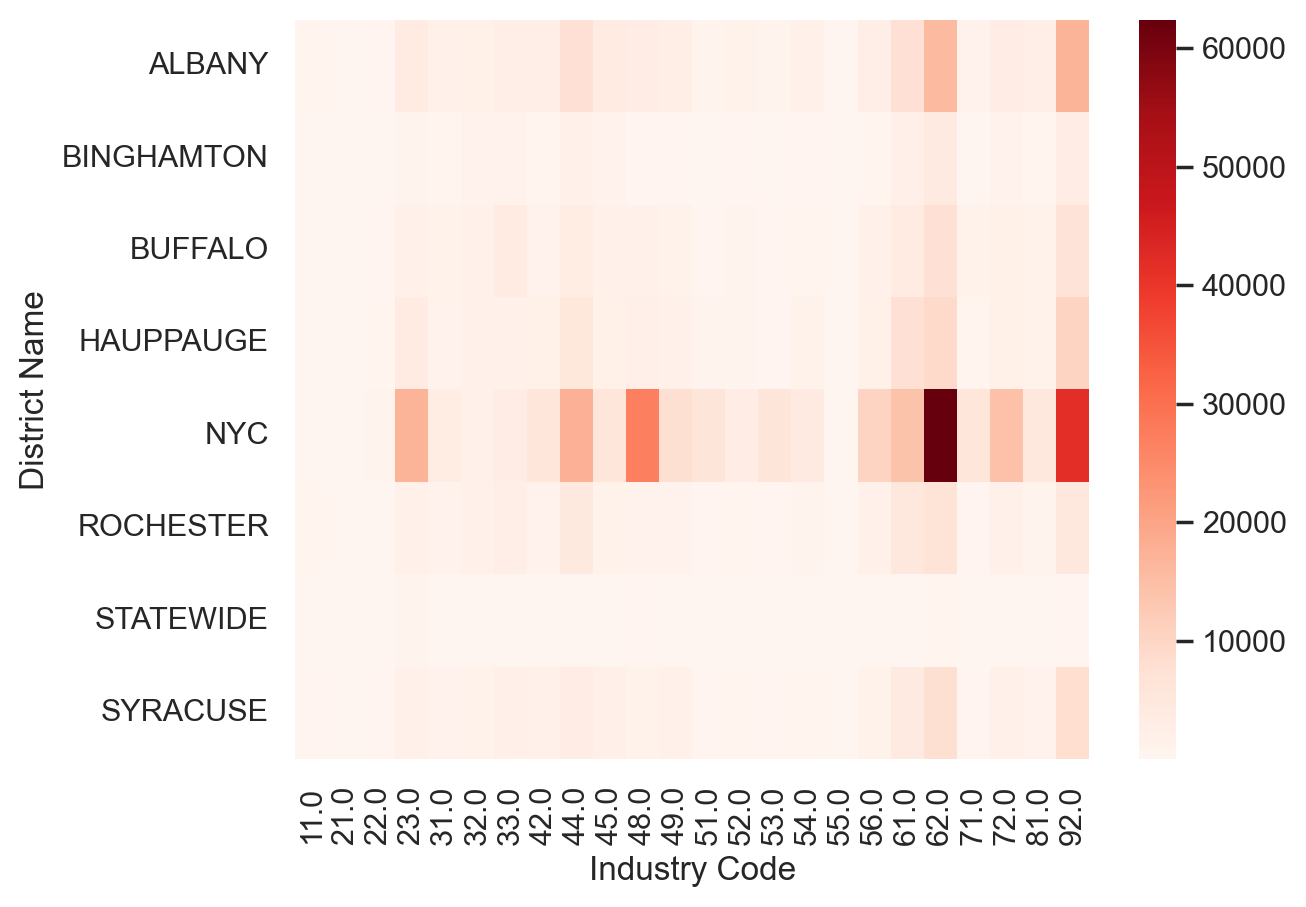

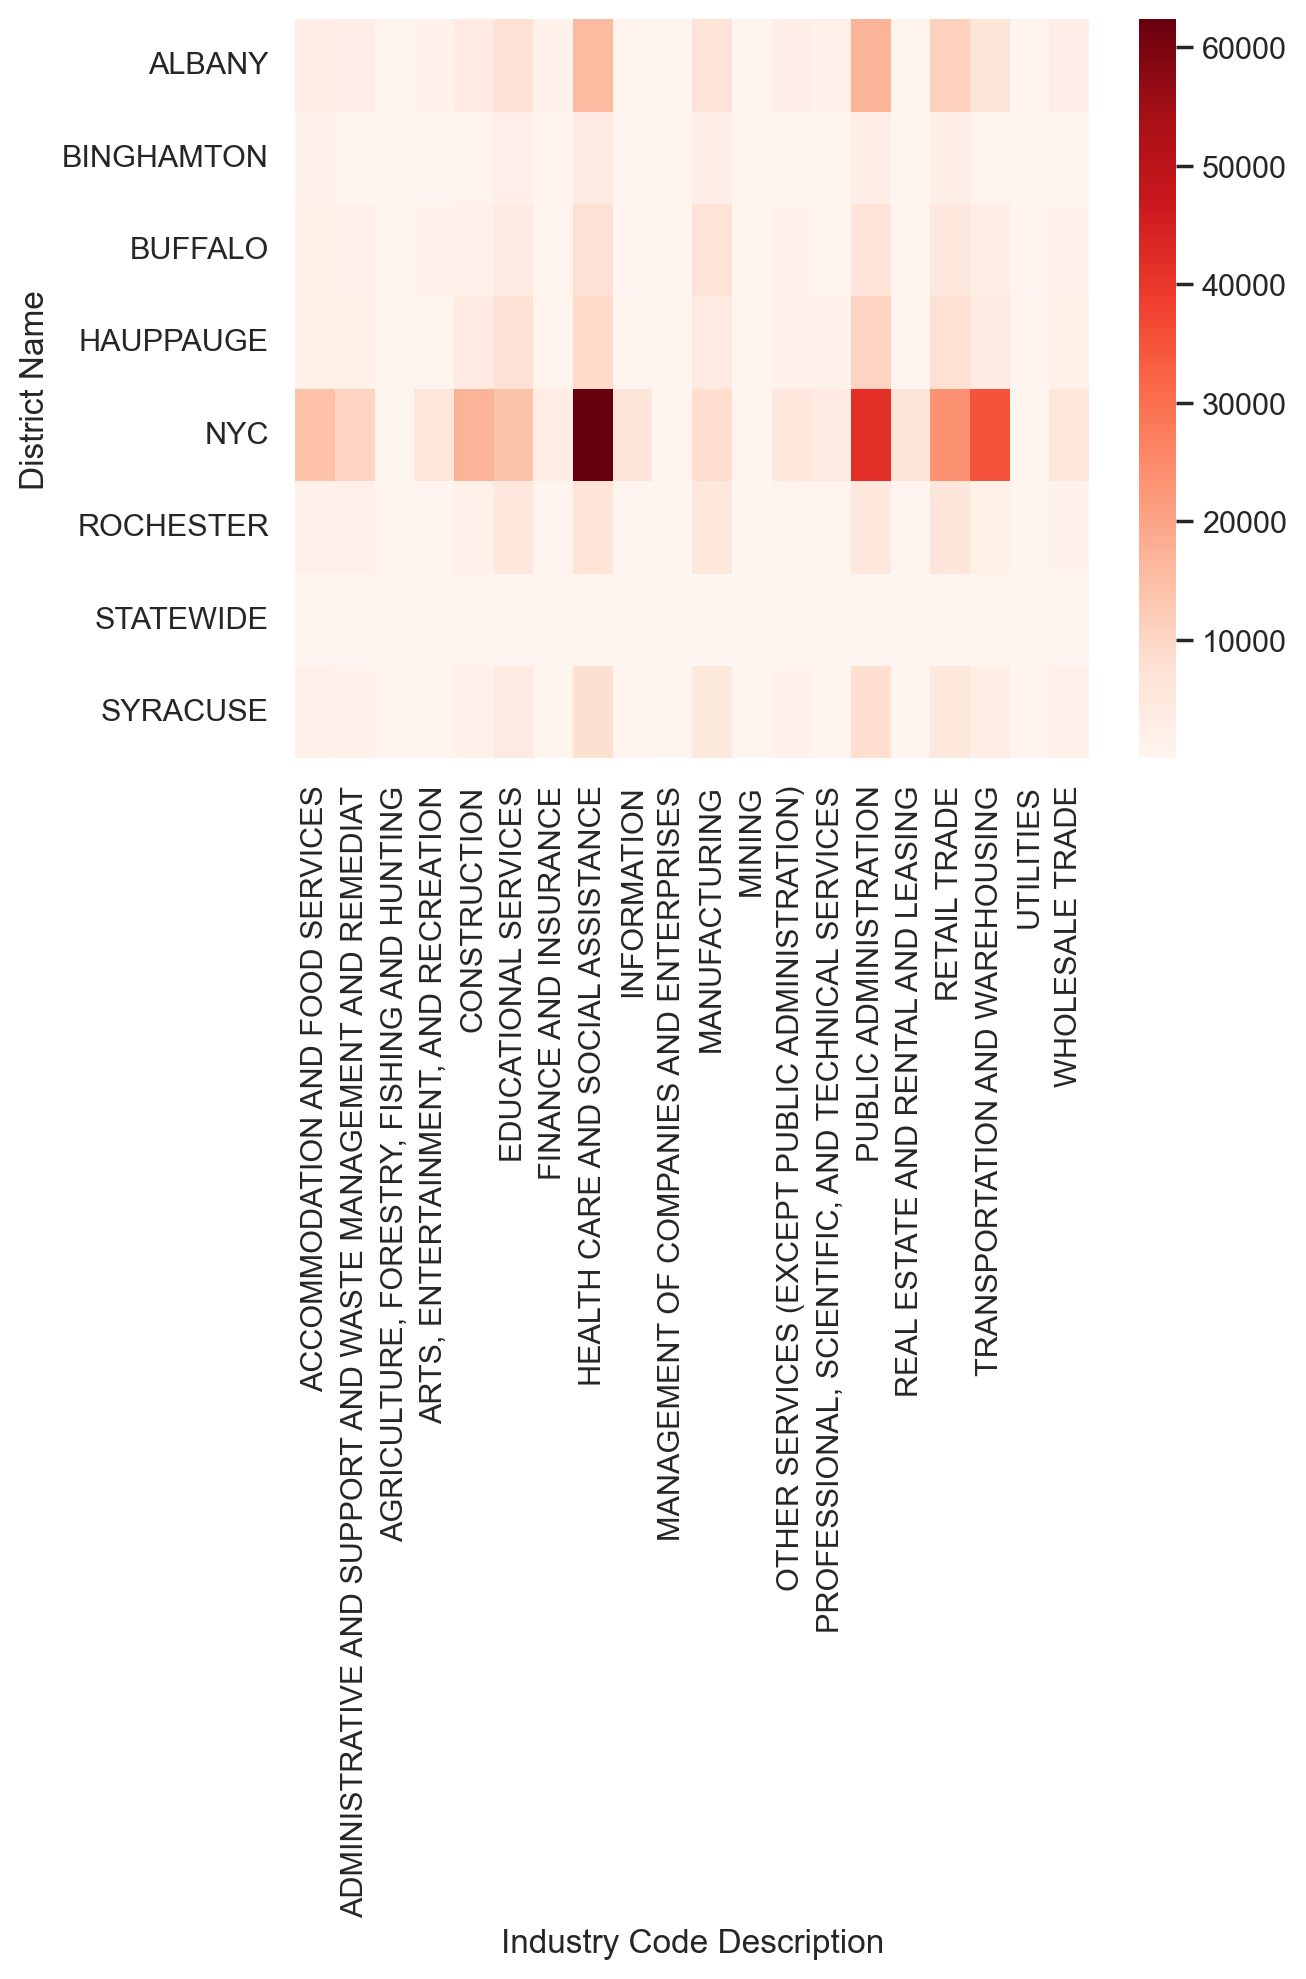

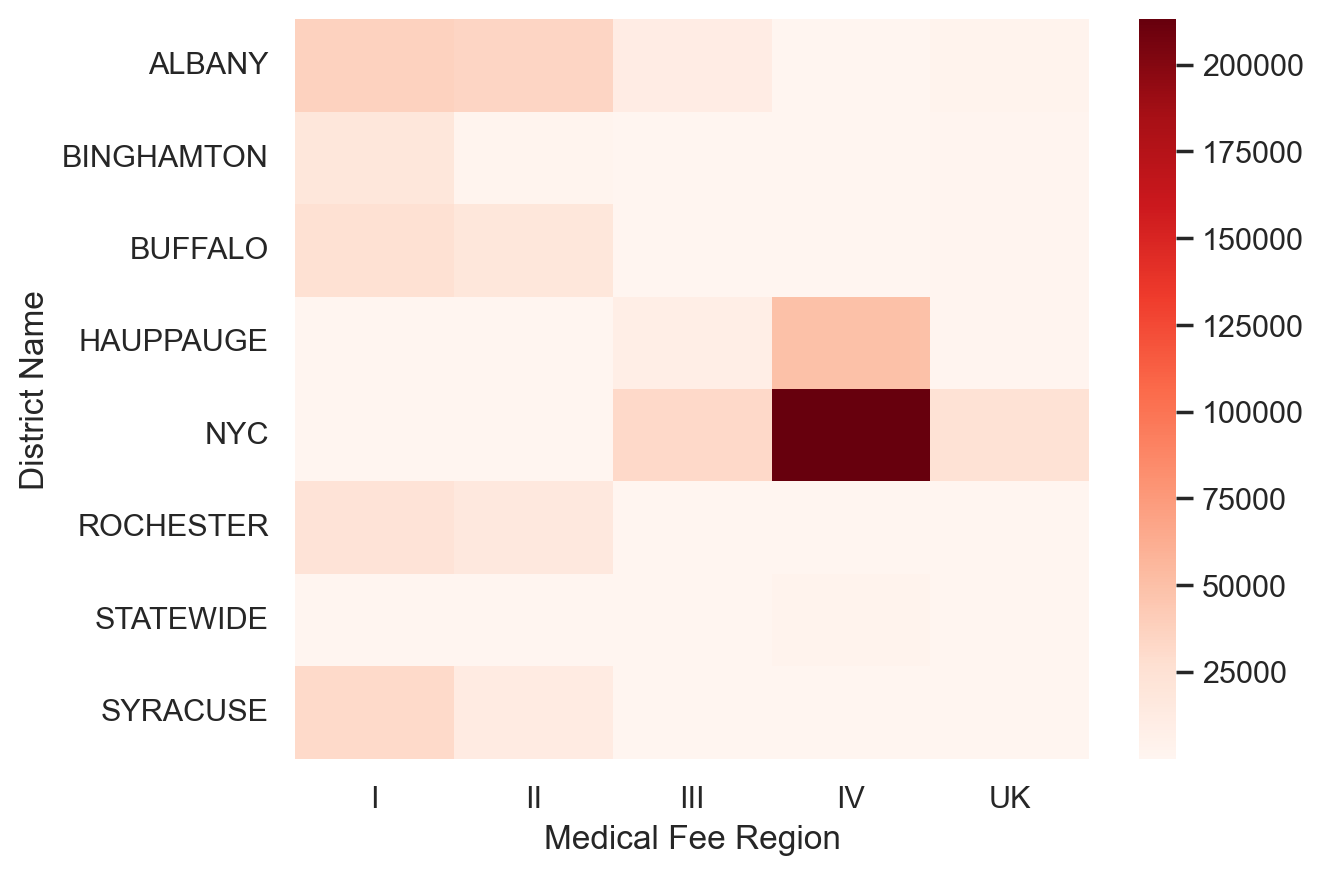

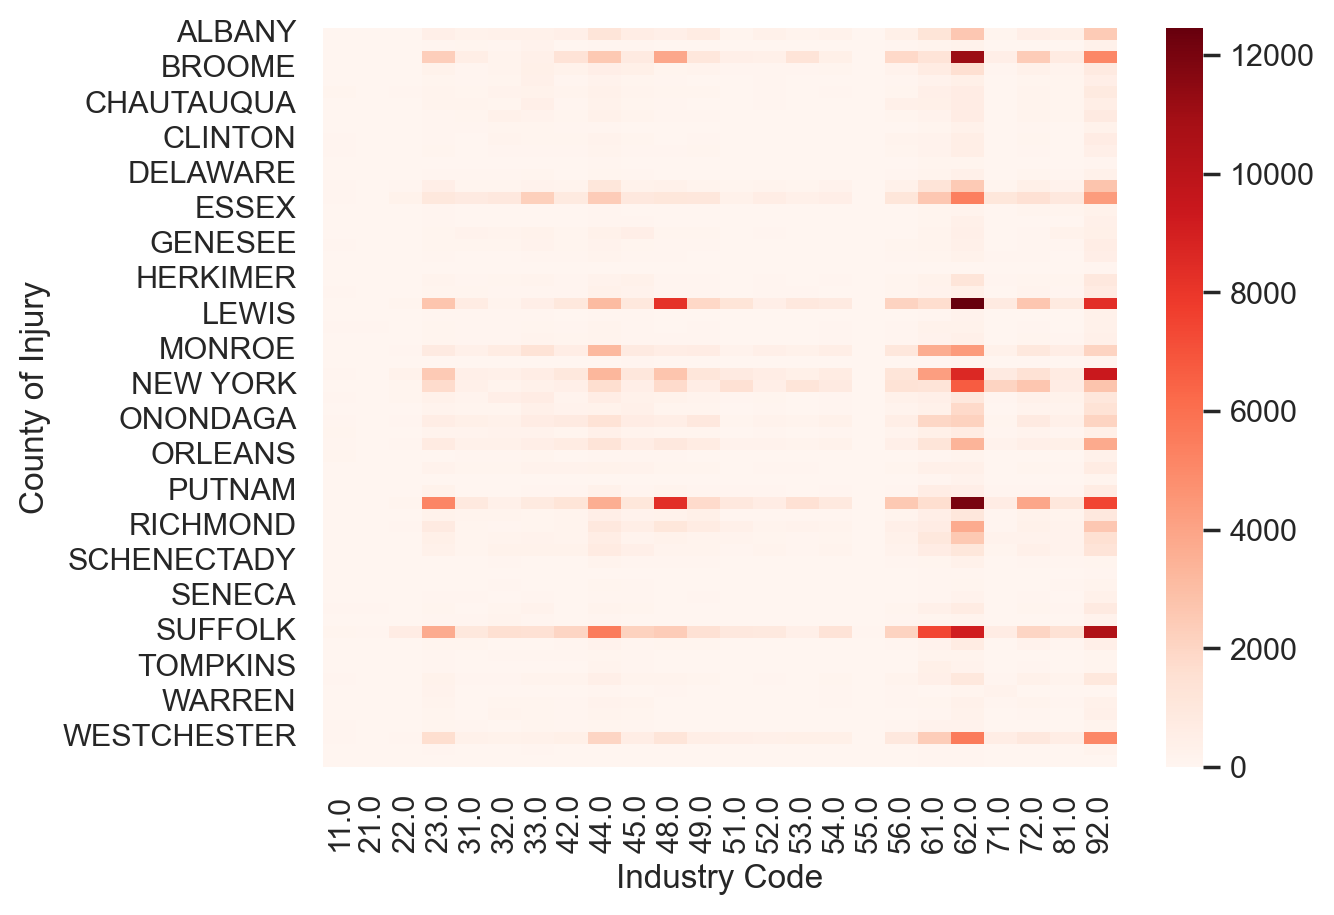

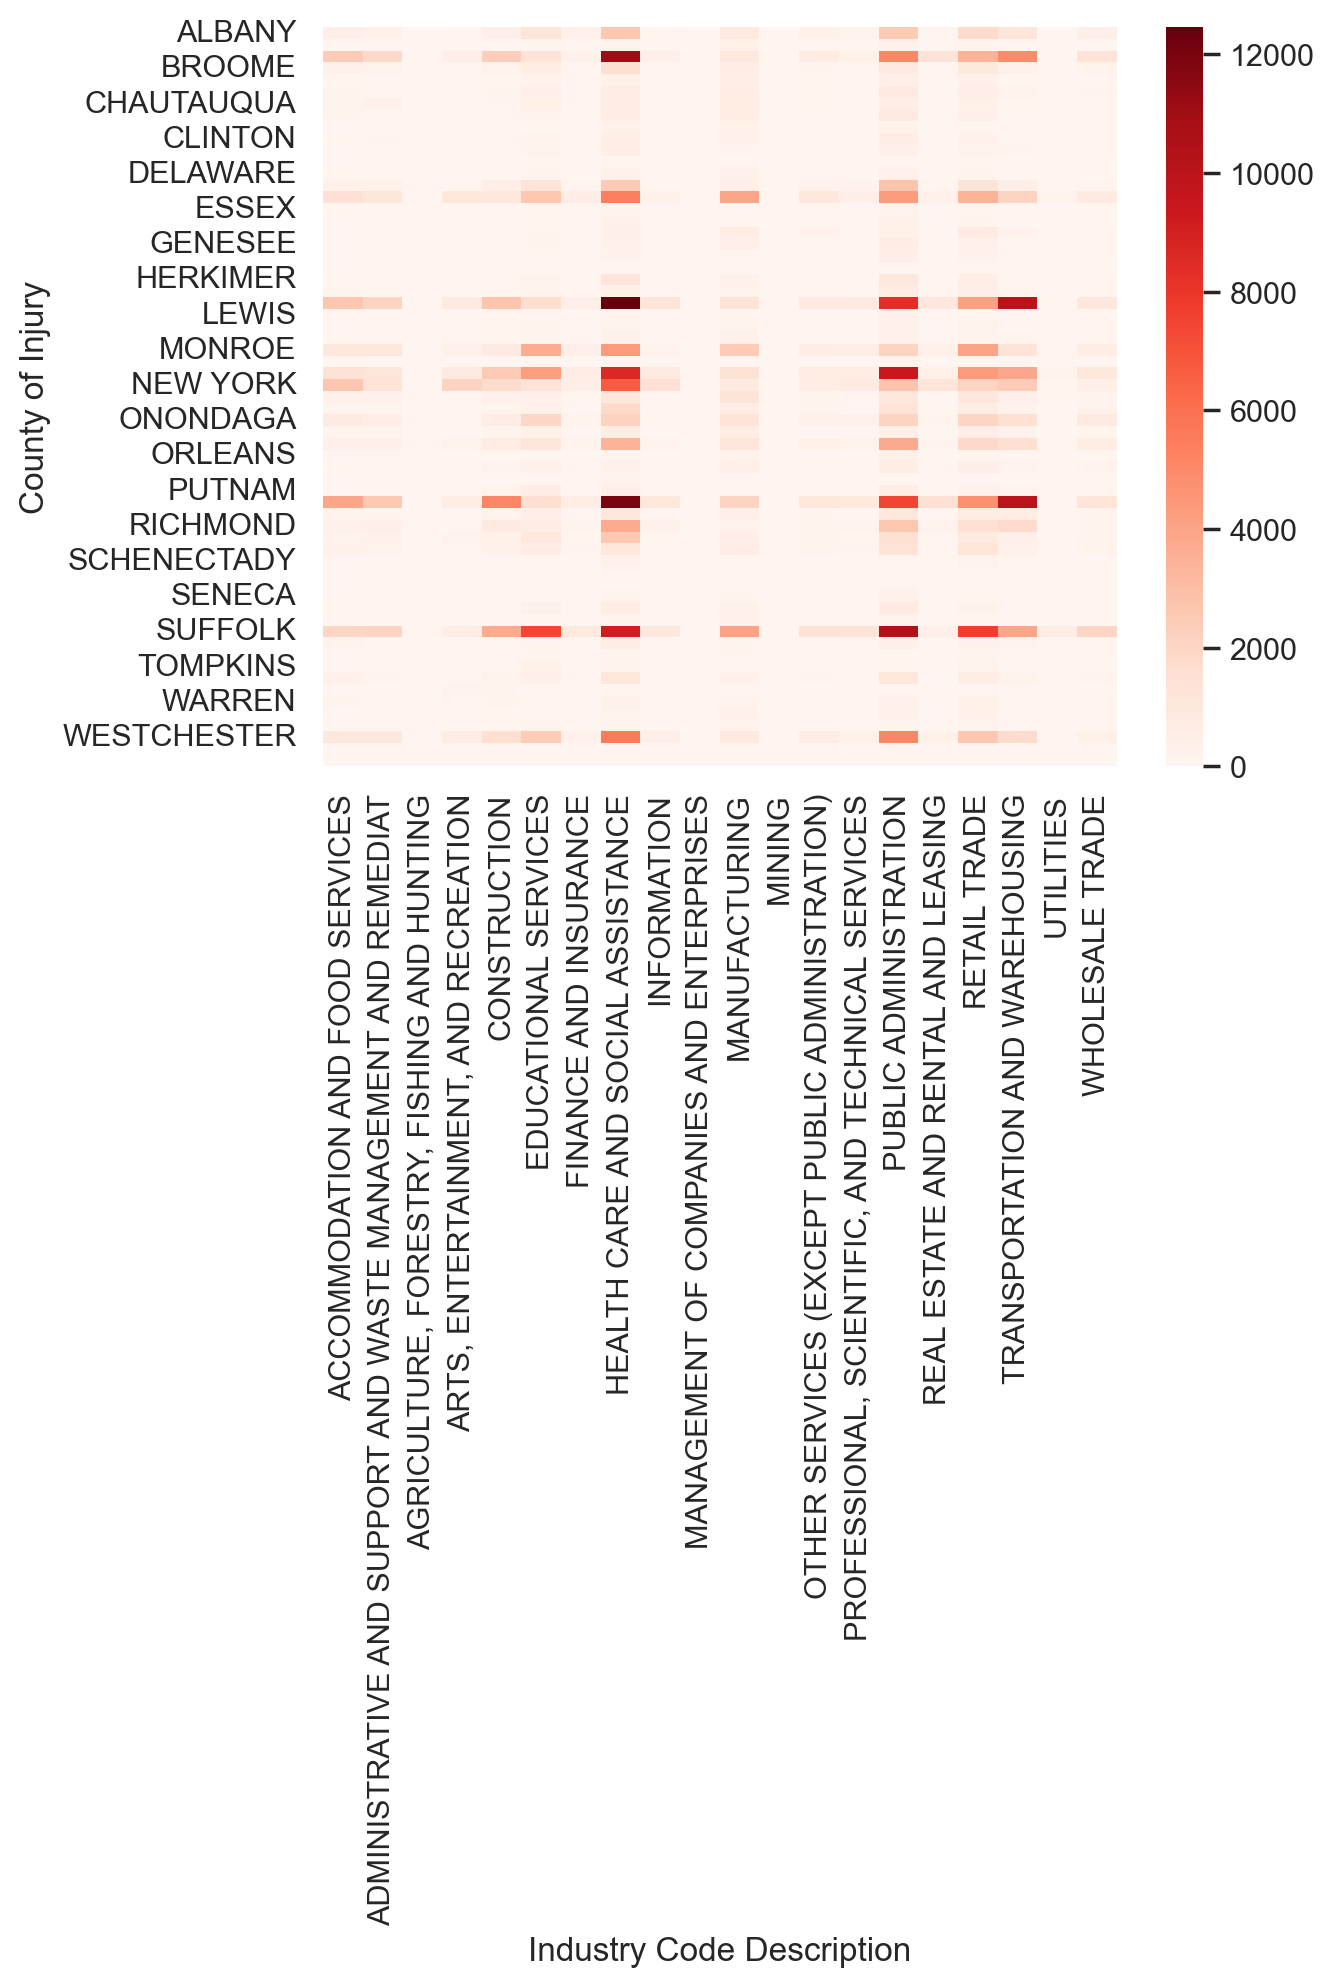

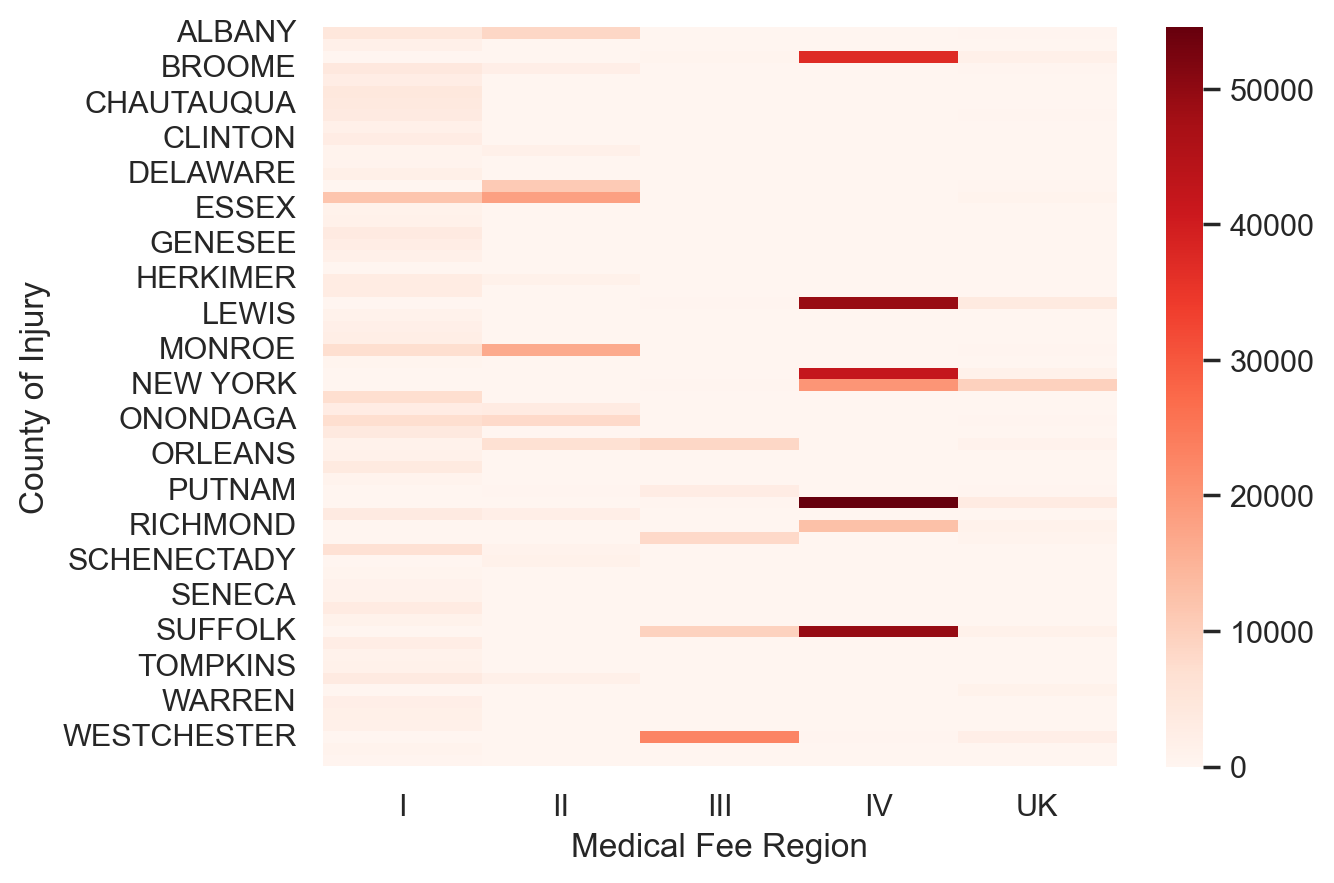

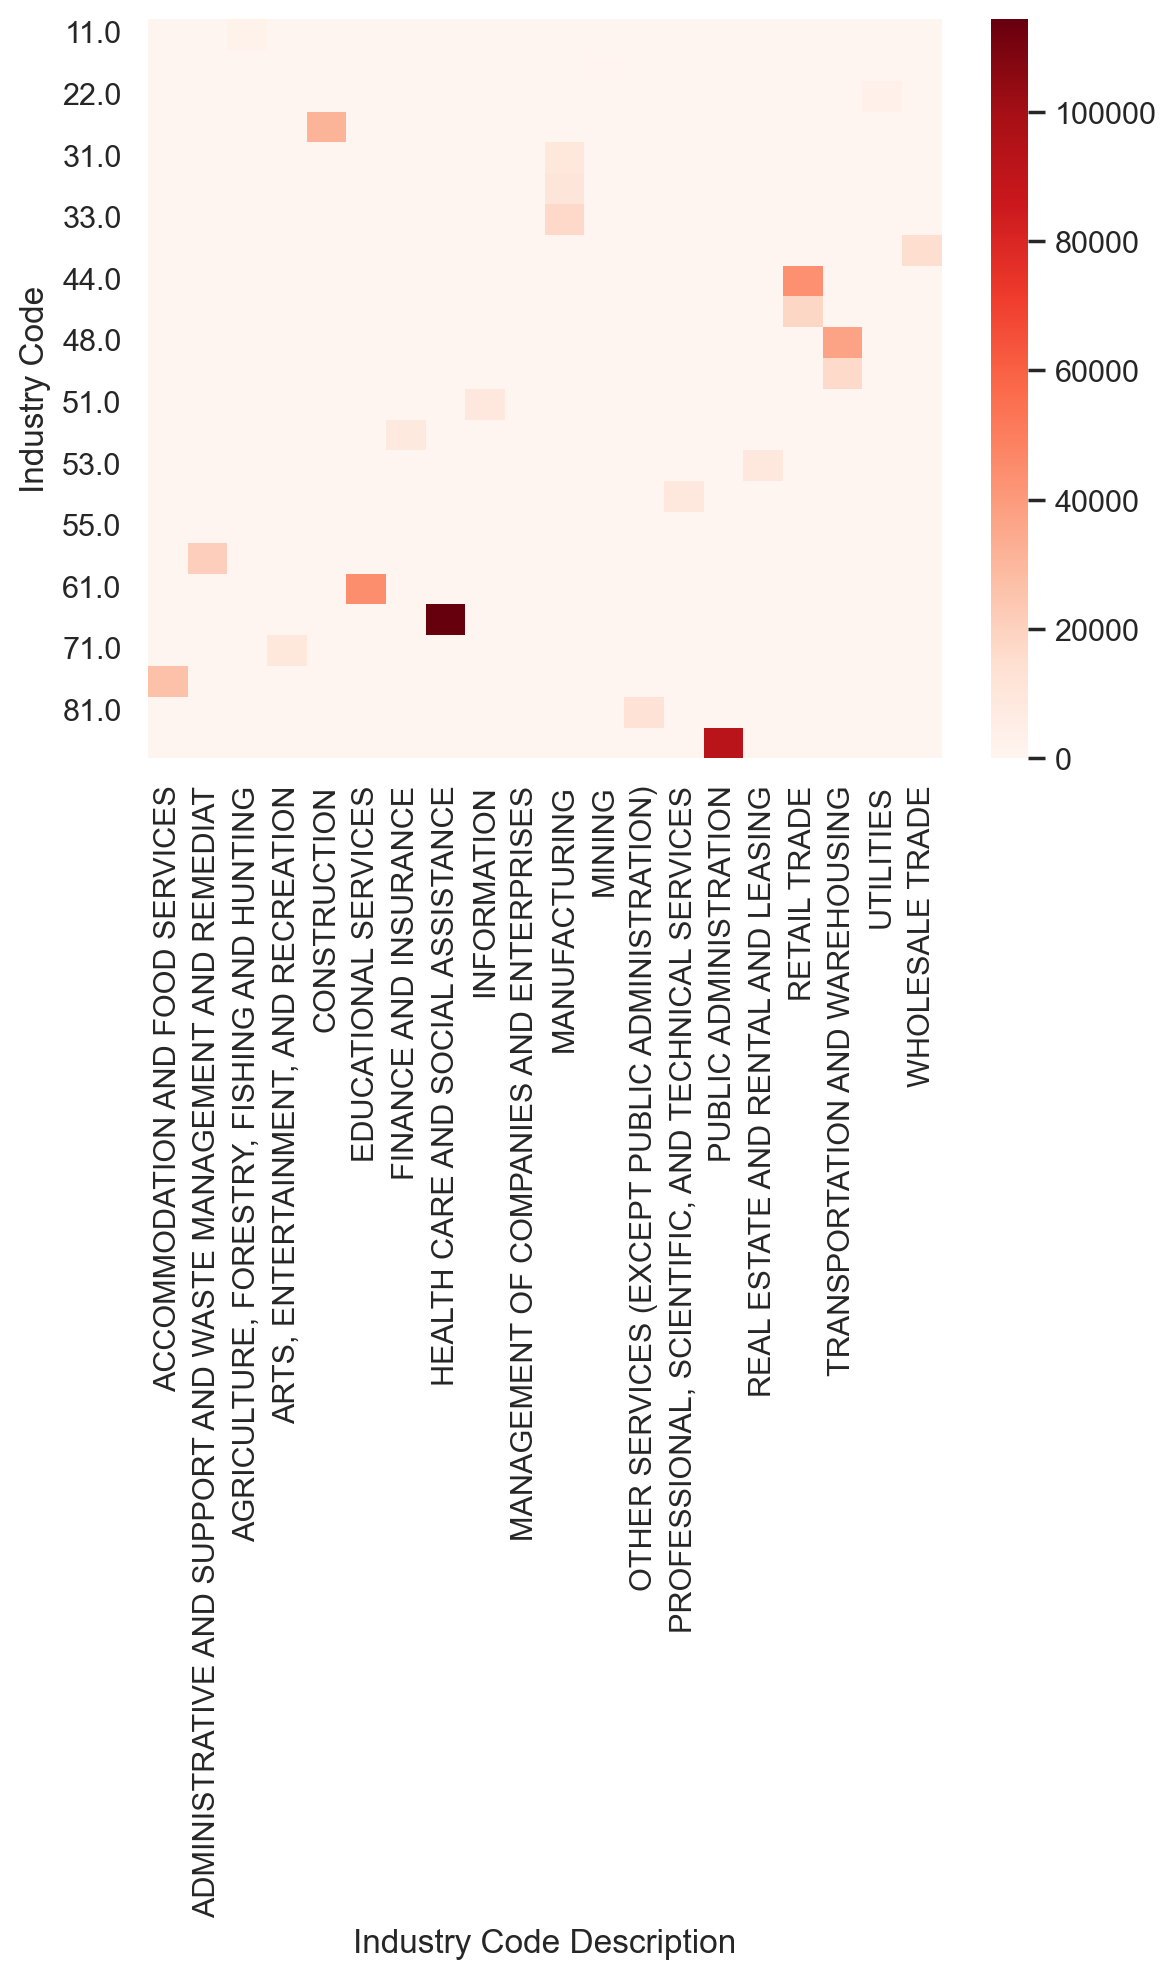

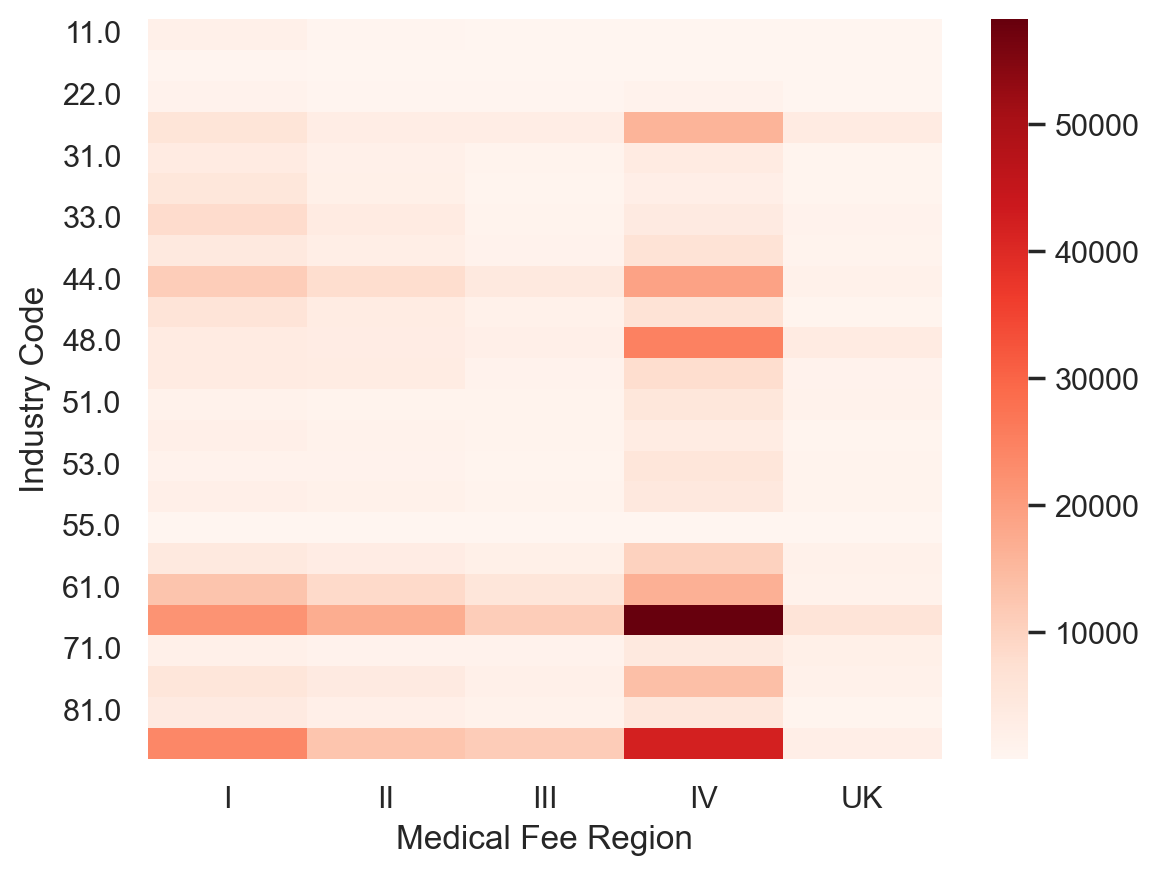

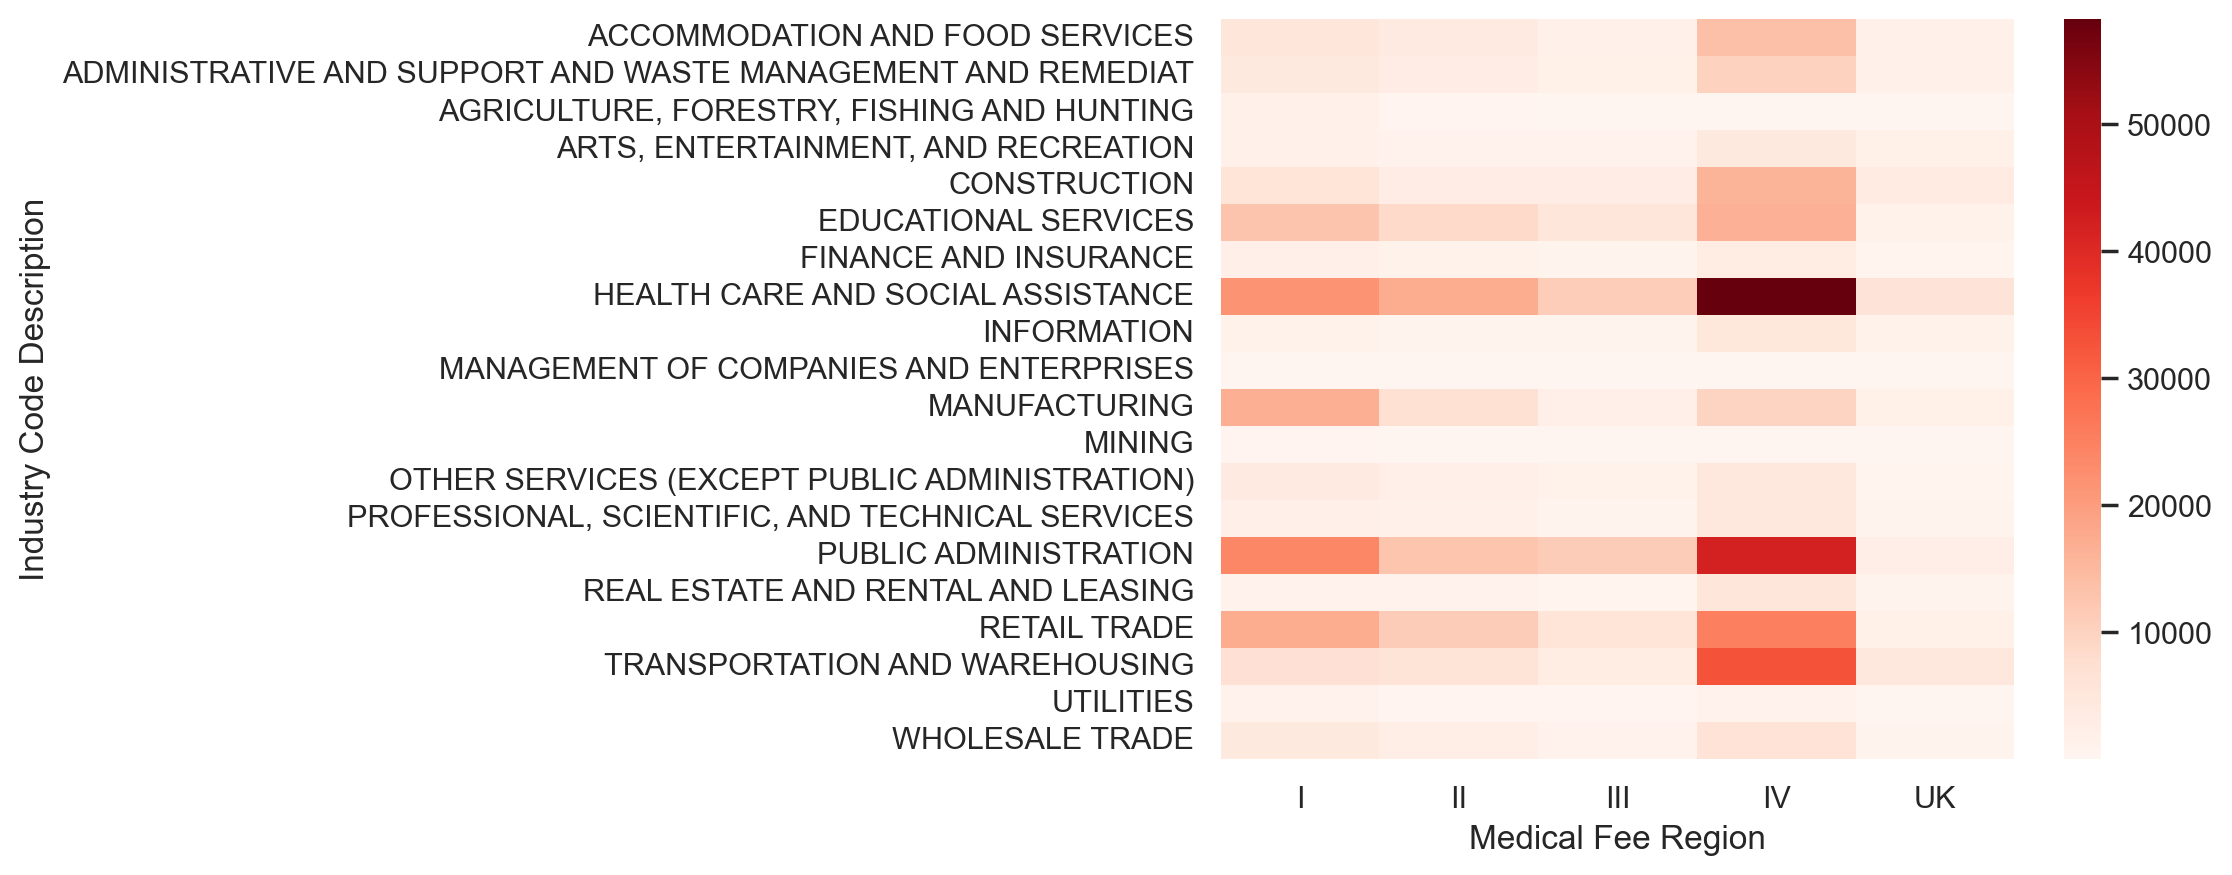

Zip Code District Name County of Injury  \
Zip Code                       NaN           0.0              0.0   
District Name                  NaN           NaN              0.0   
County of Injury               NaN           NaN              NaN   
Industry Code                  NaN           NaN              NaN   
Industry Code Description      NaN           NaN              NaN   

                          Industry Code Industry Code Description  \
Zip Code                            0.0                       0.0   
District Name                       0.0                       0.0   
County of Injury                    0.0                       0.0   
Industry Code                       NaN                       0.0   
Industry Code Description           NaN                       NaN   

                          Medical Fee Region  
Zip Code                                 0.0  
District Name                            0.0  
County of Injury                         0.0  
Industry Code                            0.0  
Industry Code Description                0.0

In [103]:
ls = rdata_train.columns.tolist()
ind_matrix = pd.DataFrame(columns=ls)
for col1 in ls:
    for col2 in ls[ls.index(col1)+1:]:  
        cross_tab = pd.crosstab(index=rdata_train[col1],columns=rdata_train[col2])
        chi_sq_result = chi2_contingency(cross_tab,)
        sns.heatmap(cross_tab, cmap='Reds')
        plt.yticks(rotation='horizontal')
        plt.show()
        p = chi_sq_result[1]
        ind_matrix.loc[col1, col2] = p

display(ind_matrix)

`It looks that every variable is fully dependent among each other, but the cross_tab plots don't agree`

In [58]:
ls = rdata_train.columns.tolist()
cramer_corr_train = pd.DataFrame(columns=ls)
for col1 in ls:
    cross_tab = pd.crosstab(index=rdata_test[col1],columns=train_target)
    corr_t = association(cross_tab, method='cramer')
    for col2 in ls[ls.index(col1):]:  
        cross_tab = pd.crosstab(index=rdata_train[col1],columns=rdata_train[col2])
        corr = association(cross_tab, method='cramer')
        cramer_corr_train.loc[col1, col2] = corr
        cramer_corr_train.loc[col1, 'target'] = corr_t

display(cramer_corr_train)

Zip Code District Name County of Injury  \
Zip Code                       1.0      0.903279         0.946721   
District Name                  NaN           1.0         0.909269   
County of Injury               NaN           NaN              1.0   
Industry Code                  NaN           NaN              NaN   
Industry Code Description      NaN           NaN              NaN   
Medical Fee Region             NaN           NaN              NaN   

                          Industry Code Industry Code Description  \
Zip Code                       0.202371                  0.209637   
District Name                    0.1166                  0.109362   
County of Injury               0.093604                  0.096431   
Industry Code                       1.0                       1.0   
Industry Code Description           NaN                       1.0   
Medical Fee Region                  NaN                       NaN   

                          Medical Fee Region    target  
Zip Code                                 1.0  0.134627  
District Name                       0.492042  0.004257  
County of Injury                    0.722477  0.013051  
Industry Code                       0.142479  0.008447  
Industry Code Description           0.135499  0.007883  
Medical Fee Region                       1.0  0.003464

`This correlation shows better the relationships`
<br>`It confirms that Industry Code and Industry Code Description give the same information`

In [60]:
ls = rdata_test.columns.tolist()
cramer_corr_test = pd.DataFrame(columns=ls)
for col1 in ls:
    for col2 in ls[ls.index(col1):]:  
        cross_tab = pd.crosstab(index=rdata_test[col1],columns=rdata_test[col2])
        corr = association(cross_tab, method='cramer')
        cramer_corr_test.loc[col1, col2] = corr

display(cramer_corr_test)

Zip Code District Name County of Injury  \
Zip Code                       1.0      0.912118         0.965664   
District Name                  NaN           1.0         0.916057   
County of Injury               NaN           NaN              1.0   
Industry Code                  NaN           NaN              NaN   
Industry Code Description      NaN           NaN              NaN   
Medical Fee Region             NaN           NaN              NaN   

                          Industry Code Industry Code Description  \
Zip Code                       0.218148                  0.227672   
District Name                   0.11961                  0.112206   
County of Injury               0.101776                  0.105973   
Industry Code                       1.0                       1.0   
Industry Code Description           NaN                       1.0   
Medical Fee Region                  NaN                       NaN   

                          Medical Fee Region  
Zip Code                                 1.0  
District Name                        0.49642  
County of Injury                    0.739637  
Industry Code                       0.158414  
Industry Code Description           0.151627  
Medical Fee Region                       1.0

In [ ]:
ls = rdata_test.columns.tolist()
for col in ls:
    cross_tab = pd.crosstab(index=rdata_test[col1],columns=rdata_test[col2])
    corr = association(cross_tab, method='cramer')
    cramer_corr_test.loc[col1, col2] = corr

In [131]:
display(cramer_corr_test-cramer_corr_train)

Zip Code District Name County of Injury  \
Zip Code                       0.0      0.008839         0.018942   
District Name                  NaN           0.0         0.006788   
County of Injury               NaN           NaN              0.0   
Industry Code                  NaN           NaN              NaN   
Industry Code Description      NaN           NaN              NaN   
Medical Fee Region             NaN           NaN              NaN   

                          Industry Code Industry Code Description  \
Zip Code                       0.015778                  0.018036   
District Name                   0.00301                  0.002844   
County of Injury               0.008172                  0.009542   
Industry Code                       0.0                       0.0   
Industry Code Description           NaN                       0.0   
Medical Fee Region                  NaN                       NaN   

                          Medical Fee Region  
Zip Code                                 0.0  
District Name                       0.004379  
County of Injury                     0.01716  
Industry Code                       0.015935  
Industry Code Description           0.016128  
Medical Fee Region                      -0.0